# *1.* IMPORT PACKAGES

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os

import matplotlib.pyplot as plt 
import seaborn as sns
import io
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from keras.callbacks import LearningRateScheduler
from datetime import datetime
from keras.utils import timeseries_dataset_from_array
# from google.colab import files
RSEED = 8 


# *2.* CHECK AND SETUP GPU

In [2]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version: 2.10.0
Keras Version: 2.10.0
GPU is available


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


---
*Comparison of CNN's vs RNN's (LSTM) vs Transformers (original positional encoding) vs Transformers (Time2Vec time representation) by forecasting the concentrations of PM2.5, using air pollution and meteorological data collected from the city of Madrid*
---

---
# *3.* DATA PRE-PROCESSING AND PLOTTING

---
- This notebook employs a dataset containing historical air quality data, recorded between 2001-2018, uploaded and available for the public on [Madrid's City Council Open Data website](https://datos.madrid.es/portal/site/egob). 
- Due to the fact that the format of the data published on the official website is quite uncommon and slightly confusing, a processed version of the dataset, more adapted to the purpose of the experiments has been used, available on [Kaggle](https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid) website. 
- The original dataset contains recordings from several air-quality measurement stations, however, in this case, the data from only one station (Madrid City Center - Retiro Park station) will be considered.
- For this forecast, historical weather information will also be used, since weather parameters are usually considered to be correlated with the levels of emissions. Weather data has been downloaded from [World Weather Online website](https://www.worldweatheronline.com/) using their weather API.
- For the sake of simplicity and efficiency, the unified dataset (pollutant concentrations and weather data) will be limited to only 5 years of data (2013 to 2017).
- The forecast consists in predicting the concentrations of PM 2.5 for the next 24 hours (multi-step prediction) based on its' historical values and those of other 25 regressor variables
---

### Read data from the .csv files, containing the concentrations of main pollutants as well as meteorological data.

- Main pollutants: 

    - 'PM2.5'   --> Particles smaller than 2.5 μm level measured in μg/m³. The size of these particles allow them to penetrate into the gas
                exchange regions of the lungs (alveolus) and even enter the arteries. Long-term exposure is proven to be related to low birth weight and high blood pressure in newborn babies.
    - 'PM10'    --> Particles smaller than 10 μm level measured in μg/m³. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and 
                affect other organs. Long term exposure can result in lung cancer and cardiovascular complications.
    - 'CO'      --> Carbon monoxide level measured in mg/m³. Carbon monoxide poisoning involves headaches, dizziness and confusion in short 
                exposures and can result in loss of consciousness, arrhythmias, seizures or even death in the long term.
    - 'NO2'     --> Nitrogen dioxide level measured in μg/m³. Long-term exposure is a cause of chronic lung diseases, and are harmful for the 
                vegetation.
    - 'NO'      --> Nitric oxide level measured in μg/m³. This is a highly corrosive gas generated among others by motor vehicles and fuel 
                burning processes.
    - 'O3'      --> Ozone level measured in μg/m³. High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive 
                groups or outdoor workers.
    - 'SO2'     --> Sulphur dioxide level measured in μg/m³. High levels of sulphur dioxide can produce irritation in the skin and membranes, 
                and worsen asthma or heart diseases in sensitive groups.
    - 'BEN'     --> Benzene level measured in μg/m³. Benzene is a eye and skin irritant, and long exposures may result in several types of 
                cancer, leukaemia and anaemias. Benzene is considered a group 1 carcinogenic to humans by the IARC.   
    - 'TOL'     --> Toluene (methylbenzene) level measured in μg/m³. Long-term exposure to this substance (present in tobacco smkoke as well) 
                can result in kidney complications or permanent brain damage.
    - 'EBE'     --> Ethylbenzene level measured in μg/m³. Long term exposure can cause hearing or kidney problems and the IARC has concluded 
                that long-term exposure can produce cancer.
</br>
- Weather parameters:

    - 'TEMP'        --> Temperature measured in degrees Celsius.
    - 'PRES'        --> Atmospheric pressure measured in mb.
    - 'RH'          --> Relative humidity expressed in a percentage representing the amount of water vapor in the air at a given temperature 
                    compared to the max possible water vapor amount at that same temperature.
    - 'PRE'      --> Precipitation measured in mm, numerically equal to the number of kilograms of water per square meter.
    - 'DWP'         --> Dew point measured in degrees Celsius is the temperature the air needs to be cooled to (at constant pressure) in order 
                    to achieve a relative humidity (RH) of 100%.
    - 'WS'     --> Wind speed measured in Km/h.
    - 'WG'      --> Wind gusts speed measured in Km/h.
    - 'WD'       --> Wind direction measured in degrees.
    - 'VIS'         --> Visibility measured in km is the measure of the distance at which an object or light can be clearly discerned.
    - 'FL'          --> Feels like measured in degrees Celsius is the apparent temperature perceived by human body, based on temperature, 
                    relative humidity and wind speed.
    - 'HI'          --> Heat index measured in degrees Celsius is the apparent temperature perceived by human body, based on temperature and 
                    relative humidity.
    - 'WC'          --> Wind chill measured in degrees Celsius is the apparent temperature perceived by human body, based on temperature and 
                    wind speed.
    - 'CC'          --> Cloud cover expressed in a percentage representing the amount of sky covered by clouds.
    - 'SH'          --> Sun hour is a count representing the number of Sun-hours in a day (i.e. 1000 watts of energy shining on 1 square meter 
                    of surface for 1 hour)
    - 'UV'          --> UV index is a dimensionless measure of the strength of the sunburn-producing ultraviolet radiation at a particular place 
                    and time.
    - 'MIL'         --> Moon illumination is a percentage representing the partition of the moon illuminated by the sun.

## *3.1* Load air quality data

In [4]:
import glob
# get a list of csv files paths
csv_paths = glob.glob(os.path.join(os.getcwd(), 'datasets\madrid\csvs_per_year', '*.csv'))

years = []

for p in csv_paths[-7:-1]:

    # read .csv files for each year
    year = pd.read_csv(p)
    year.index = pd.to_datetime(year['date'])
    year.index.name = 'date'
    
    # lowercase column names
    year.columns = year.columns.str.lower()

    # keep only the observations from Madrid city center - Retiro park station
    year = year[year['station'] == 28079008]

    # drop the "date" and "station" columns
    year.drop(['date', 'station'] , axis=1, inplace=True)

    # replace 'NA' texts and empty spaces with np.nan
    year = year.replace(['NA', ''], np.nan)

    # fill missing observations with interpolated values in case of small gaps, up to 3 hours
    year.interpolate(method='time', axis='index', limit=3, limit_direction='forward', inplace=True)

    # populate the list of df's for all observation sites
    years.append(year)

# create the dataframe containing all read years of data
df = pd.concat(years)
df.sort_index(inplace=True)
df.info()
print(df.isna().sum())
# check the percentage of missing values for each column and drop pollutants having more than 10% of values missing
percent_missing = df.isnull().sum()* 100 / len(df)
drop_df = percent_missing[percent_missing.loc[percent_missing > 10].index.tolist()]
if len(drop_df.index) > 0:
    df.drop(list(drop_df.index) , axis=1, inplace=True)

# select six full years of hourly observations, from 2012 to 2017 inclusive
df = df[df.index.year.isin(range(2012, 2018))]
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52368 entries, 2012-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ben     51837 non-null  float64
 1   co      52217 non-null  float64
 2   ebe     51818 non-null  float64
 3   nmhc    35802 non-null  float64
 4   no      52181 non-null  float64
 5   no_2    52181 non-null  float64
 6   o_3     52217 non-null  float64
 7   pm10    52048 non-null  float64
 8   pm25    51681 non-null  float64
 9   so_2    52197 non-null  float64
 10  tch     35802 non-null  float64
 11  tol     51781 non-null  float64
 12  ch4     2214 non-null   float64
 13  nox     2214 non-null   float64
dtypes: float64(14)
memory usage: 6.0 MB
ben       531
co        151
ebe       550
nmhc    16566
no        187
no_2      187
o_3       151
pm10      320
pm25      687
so_2      171
tch     16566
tol       587
ch4     50154
nox     50154
dtype: int64


ben   co  ebe     no   no_2  o_3   pm10  pm25  so_2   tol
date                                                                          
2012-01-01 01:00:00  3.4  1.2  2.4  232.0  114.0  4.0   93.0  66.0  26.0   8.7
2012-01-01 02:00:00  4.1  1.3  3.5  253.0  120.0  3.0  121.0  93.0  25.0  10.9
2012-01-01 03:00:00  4.1  1.0  4.2  196.0  106.0  3.0   97.0  82.0  24.0  10.8
2012-01-01 04:00:00  2.8  0.5  2.7   72.0   71.0  3.0   40.0  32.0  18.0   7.3
2012-01-01 05:00:00  2.1  0.4  1.5   51.0   64.0  3.0   32.0  24.0  15.0   5.5

## *3.2* Load weather data

In [5]:
weather = pd.read_csv(os.path.join(os.getcwd(), 'D:\MASTER_SU\THESIS\datasets\madrid','madrid_retiro_weather_clean.csv'))
weather.index = pd.to_datetime(weather['date_time'])
weather.index.name = 'date'
weather.drop(['date_time'], axis=1, inplace=True)
print(weather.columns)
weather.rename(columns={'tempC':'temp', 'pressure':'pres', 'humidity':'rh', 'precipMM':'pre', 'windspeedKmph':'ws',
                'WindGustKmph':'wg', 'winddirDegree':'wd', 'WindChillC':'wc','DewPointC':'dwp',
                'HeatIndexC':'hi', 'FeelsLikeC':'fl', 'visibility':'vis', 'cloudcover':'cc', 'sunHour':'sh',
                'uvIndex':'uv', 'moon_illumination':'mil'}, inplace=True)
weather  = weather[weather.index.year.isin(range(2012, 2018))]
weather.info()
print(weather.isna().sum())
weather.head()

Index(['tempC', 'pressure', 'humidity', 'precipMM', 'windspeedKmph',
       'WindGustKmph', 'winddirDegree', 'WindChillC', 'DewPointC',
       'HeatIndexC', 'FeelsLikeC', 'visibility', 'cloudcover', 'sunHour',
       'uvIndex', 'moon_illumination'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2012-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    52608 non-null  int64  
 1   pres    52608 non-null  int64  
 2   rh      52608 non-null  int64  
 3   pre     52608 non-null  float64
 4   ws      52608 non-null  int64  
 5   wg      52608 non-null  int64  
 6   wd      52608 non-null  int64  
 7   wc      52608 non-null  int64  
 8   dwp     52608 non-null  int64  
 9   hi      52608 non-null  int64  
 10  fl      52608 non-null  int64  
 11  vis     52608 non-null  int64  
 12  cc      52608 non-null  int64  
 13  sh      52608 non-null  

temp  pres  rh  pre  ws  wg  wd  wc  dwp  hi  fl  vis  \
date                                                                         
2012-01-01 00:00:00     6  1031  86  0.0   5  11   0   5    4   6   5   10   
2012-01-01 01:00:00     5  1030  87  0.0   5  11   4   5    3   5   5   10   
2012-01-01 02:00:00     5  1030  87  0.0   5  11   7   4    3   5   4   10   
2012-01-01 03:00:00     5  1030  87  0.0   5  11  11   4    3   5   4   10   
2012-01-01 04:00:00     4  1030  88  0.0   4   9  45   3    2   4   3   10   

                     cc   sh  uv  mil  
date                                   
2012-01-01 00:00:00   5  8.7   3   48  
2012-01-01 01:00:00   5  8.7   3   48  
2012-01-01 02:00:00   5  8.7   3   48  
2012-01-01 03:00:00   5  8.7   3   48  
2012-01-01 04:00:00   6  8.7   3   48

## *3.3* Merge air quality and weather data

In [6]:
df1 = pd.concat([df, weather], axis=1)
print(len(df1.columns))
pd.set_option('display.max_columns', 30)
df1.head(None)

26


ben   co  ebe     no   no_2   o_3   pm10  pm25  so_2  \
date                                                                        
2012-01-01 00:00:00  NaN  NaN  NaN    NaN    NaN   NaN    NaN   NaN   NaN   
2012-01-01 01:00:00  3.4  1.2  2.4  232.0  114.0   4.0   93.0  66.0  26.0   
2012-01-01 02:00:00  4.1  1.3  3.5  253.0  120.0   3.0  121.0  93.0  25.0   
2012-01-01 03:00:00  4.1  1.0  4.2  196.0  106.0   3.0   97.0  82.0  24.0   
2012-01-01 04:00:00  2.8  0.5  2.7   72.0   71.0   3.0   40.0  32.0  18.0   
...                  ...  ...  ...    ...    ...   ...    ...   ...   ...   
2017-12-31 19:00:00  0.4  0.2  0.1    6.0   39.0  42.0    4.0   3.0   2.0   
2017-12-31 20:00:00  0.5  0.3  0.1    4.0   43.0  45.0    4.0   4.0   3.0   
2017-12-31 21:00:00  0.5  0.3  0.1    4.0   40.0  50.0    6.0   5.0   3.0   
2017-12-31 22:00:00  0.6  0.3  0.1   13.0   64.0  33.0    5.0   3.0   3.0   
2017-12-31 23:00:00  0.6  0.3  0.1    6.0   42.0  47.0    7.0   4.0   3.0   

                      tol  temp  pres  rh  pre  ws  wg   wd  wc  dwp  hi  fl  \
date                                                                           
2012-01-01 00:00:00   NaN     6  1031  86  0.0   5  11    0   5    4   6   5   
2012-01-01 01:00:00   8.7     5  1030  87  0.0   5  11    4   5    3   5   5   
2012-01-01 02:00:00  10.9     5  1030  87  0.0   5  11    7   4    3   5   4   
2012-01-01 03:00:00  10.8     5  1030  87  0.0   5  11   11   4    3   5   4   
2012-01-01 04:00:00   7.3     4  1030  88  0.0   4   9   45   3    2   4   3   
...                   ...   ...   ...  ..  ...  ..  ..  ...  ..  ...  ..  ..   
2017-12-31 19:00:00   0.6     9  1027  74  0.2  22  33  292   6    5   9   6   
2017-12-31 20:00:00   0.7     8  1028  70  0.0  20  31  294   5    3   8   5   
2017-12-31 21:00:00   0.6     7  1030  67  0.0  19  30  296   4    2   7   4   
2017-12-31 22:00:00   0.8     7  1031  68  0.0  17  26  290   4    2   7   4   
2017-12-31 23:00:00   0.9     7  1032  70  0.0  15  22  284   5    2   7   5   

                     vis  cc   sh  uv  mil  
date                                        
2012-01-01 00:00:00   10   5  8.7   3   48  
2012-01-01 01:00:00   10   5  8.7   3   48  
2012-01-01 02:00:00   10   5  8.7   3   48  
2012-01-01 03:00:00   10   5  8.7   3   48  
2012-01-01 04:00:00   10   6  8.7   3   48  
...                  ...  ..  ...  ..  ...  
2017-12-31 19:00:00    9  30  7.0   2   88  
2017-12-31 20:00:00   10  15  7.0   2   88  
2017-12-31 21:00:00   10   0  7.0   2   88  
2017-12-31 22:00:00   10   0  7.0   2   88  
2017-12-31 23:00:00   10   0  7.0   2   88  

[52608 rows x 26 columns]

In [7]:
# bring the variable to be predicted (PM2.5 --> pm25) to the first position
temp_cols=df1.columns.tolist()
index=df1.columns.get_loc('pm25')
new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
df1=df1[new_cols]
df1.head()

pm25  ben   co  ebe     no   no_2  o_3   pm10  so_2  \
date                                                                       
2012-01-01 00:00:00   NaN  NaN  NaN  NaN    NaN    NaN  NaN    NaN   NaN   
2012-01-01 01:00:00  66.0  3.4  1.2  2.4  232.0  114.0  4.0   93.0  26.0   
2012-01-01 02:00:00  93.0  4.1  1.3  3.5  253.0  120.0  3.0  121.0  25.0   
2012-01-01 03:00:00  82.0  4.1  1.0  4.2  196.0  106.0  3.0   97.0  24.0   
2012-01-01 04:00:00  32.0  2.8  0.5  2.7   72.0   71.0  3.0   40.0  18.0   

                      tol  temp  pres  rh  pre  ws  wg  wd  wc  dwp  hi  fl  \
date                                                                          
2012-01-01 00:00:00   NaN     6  1031  86  0.0   5  11   0   5    4   6   5   
2012-01-01 01:00:00   8.7     5  1030  87  0.0   5  11   4   5    3   5   5   
2012-01-01 02:00:00  10.9     5  1030  87  0.0   5  11   7   4    3   5   4   
2012-01-01 03:00:00  10.8     5  1030  87  0.0   5  11  11   4    3   5   4   
2012-01-01 04:00:00   7.3     4  1030  88  0.0   4   9  45   3    2   4   3   

                     vis  cc   sh  uv  mil  
date                                        
2012-01-01 00:00:00   10   5  8.7   3   48  
2012-01-01 01:00:00   10   5  8.7   3   48  
2012-01-01 02:00:00   10   5  8.7   3   48  
2012-01-01 03:00:00   10   5  8.7   3   48  
2012-01-01 04:00:00   10   6  8.7   3   48

## *3.4* Data visualization

In [8]:
# insert data plots from separate notebook

# %run "aq_data_visualization.ipynb"

## *3.5* Feature enginering

### *3.5.1* Wind direction and speed

Text(0, 0.5, 'Wind Velocity [m/s]')

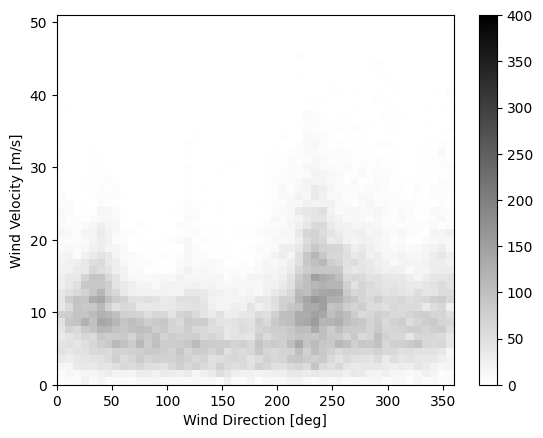

In [9]:
plt.hist2d(df1['wd'], df1['ws'], bins=(50, 50), vmax=400, cmap='gist_yarg')
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Text(0, 0.5, 'Wind Gusts Velocity [m/s]')

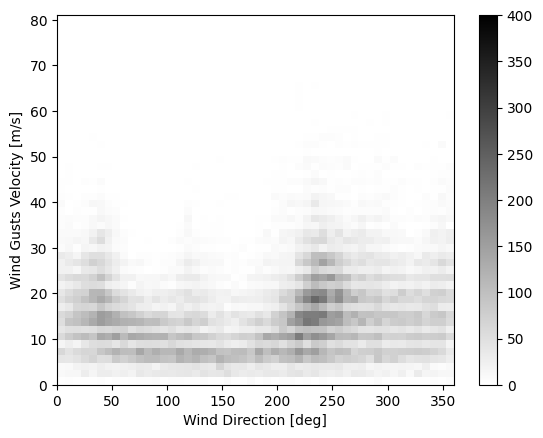

In [10]:
plt.hist2d(df1['wd'], df1['wg'], bins=(50, 50), vmax=400, cmap='gist_yarg')
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Gusts Velocity [m/s]')

In [11]:
w_speed = df1.pop('ws')
w_gust = df1.pop('wg')
# Convert wind direction to radians.
wd_rad = df1.pop('wd')*np.pi / 180
# Calculate the wind x and y components.
df1['wx'] = w_speed*np.cos(wd_rad)
df1['wy'] = w_speed*np.sin(wd_rad)
# Calculate the wind gust x and y components.
df1['wgx'] = w_gust*np.cos(wd_rad)
df1['wgy'] = w_gust*np.sin(wd_rad)

(-35.247650216593904,
 44.972587215859306,
 -48.523135368336945,
 33.960350419659875)

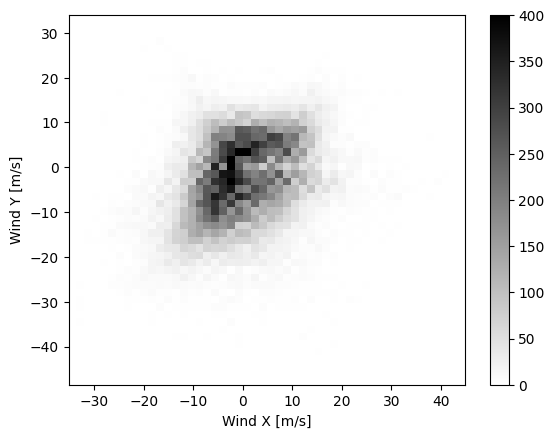

In [12]:
plt.hist2d(df1['wx'], df1['wy'], bins=(50, 50), vmax=400, cmap='gist_yarg')
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

(-52.47718242836375, 80.39623828294708, -71.29930094939307, 47.61260175135729)

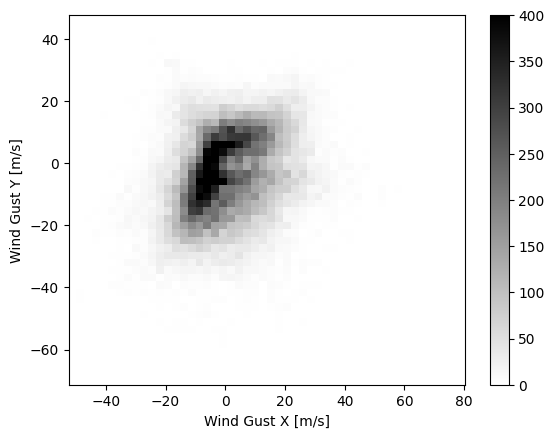

In [13]:
plt.hist2d(df1['wgx'], df1['wgy'], bins=(50, 50), vmax=400, cmap='gist_yarg')
plt.colorbar()
plt.xlabel('Wind Gust X [m/s]')
plt.ylabel('Wind Gust Y [m/s]')
ax = plt.gca()
ax.axis('tight')

### *3.5.2* Time features
`Time information included in the DateTime index will is extracted and appended to the datased as separate features. The resulting features (year, month, day, weekday, hour) will be later used in one of the prediction models for temporal positional encoding.`

In [14]:
df1['t_y'] = df1.index.year
df1['t_m'] = df1.index.month
df1['t_d'] = df1.index.day
df1['t_wd'] = df1.index.weekday
df1['t_h'] = df1.index.hour

## *3.6* Data normalization with MinMax Scaler and fill missing values
`In the plot below can be noticed that weather data is complete, however, there are missing values in the air quality measurements. Given that all pollutant parameters exhibit a certain degree of yearly ciclicity, it is considered resonable to fill the missing values with recordings of the previous (or next) year.`

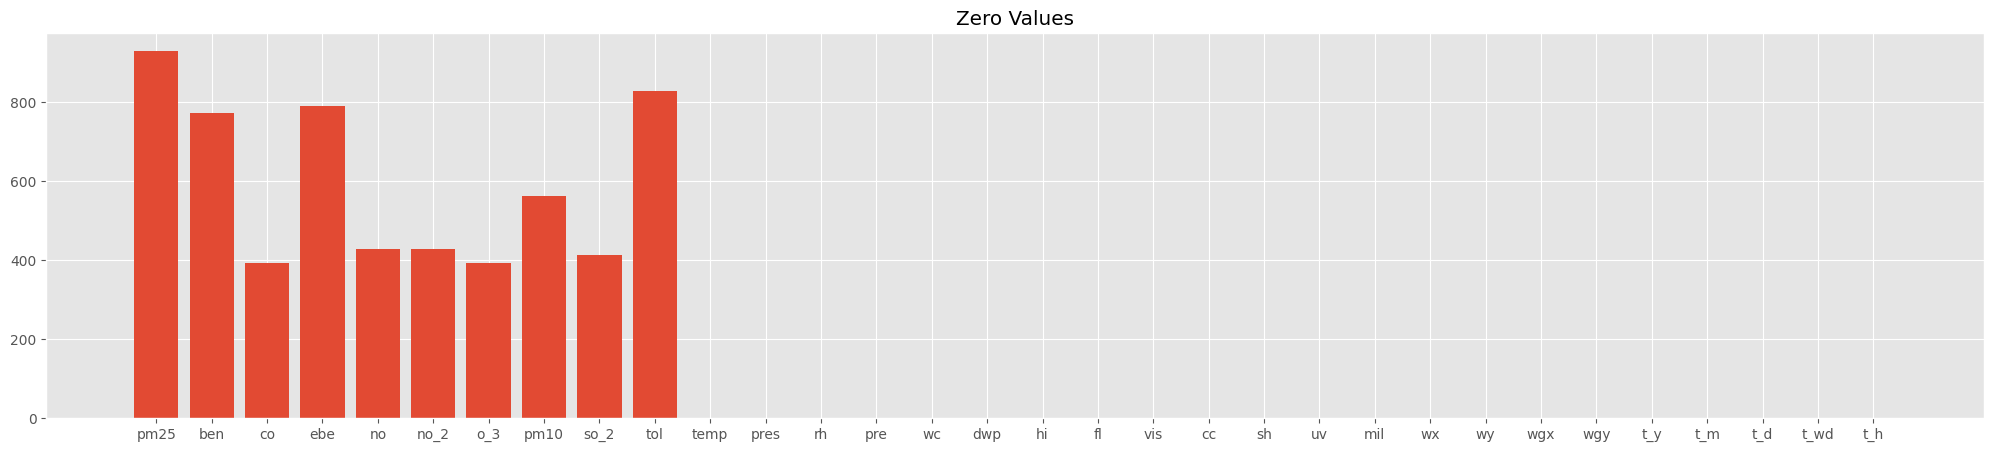

In [15]:
zero_values = pd.isna(df1).sum(axis=0)

plt.style.use('ggplot')

fig = plt.figure()
fig.set_size_inches(25,5)

ax = fig.add_subplot()
ax.bar(df1.columns, zero_values)
ax.set_title("Zero Values")
ax.set_xticks(df1.columns)
ax.grid(visible=True)

In [16]:
# fill missing values with previous year recordings
df1 = df1.groupby([df1.index.month, df1.index.day, df1.index.hour]).ffill()

# for 2012, fill missing values with next year recordings (since no previous year available)
df1 = df1.groupby([df1.index.month, df1.index.day, df1.index.hour]).bfill()

df2 = df1.copy()
df2_data = df2.values

# data normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler_pm25 = MinMaxScaler()
for i,name in enumerate(df2.columns):
    if i==0:
        slice = scaler_pm25.fit_transform(df2_data[:,i][...,np.newaxis])
    else:
        slice = scaler.fit_transform(df2_data[:,i][...,np.newaxis])
    df2[name] = slice

In [17]:
# check if any missing values are still left
print(df2.isna().sum().sum())

# overview of the normalized data
df2.head()

0


pm25       ben        co       ebe        no  \
date                                                                    
2012-01-01 00:00:00  0.032558  0.046154  0.019417  0.015707  0.006257   
2012-01-01 01:00:00  0.306977  0.169231  0.106796  0.060209  0.240876   
2012-01-01 02:00:00  0.432558  0.205128  0.116505  0.089005  0.262774   
2012-01-01 03:00:00  0.381395  0.205128  0.087379  0.107330  0.203337   
2012-01-01 04:00:00  0.148837  0.138462  0.038835  0.068063  0.074035   

                         no_2       o_3      pm10      so_2       tol  \
date                                                                    
2012-01-01 00:00:00  0.071233  0.055276  0.010929  0.084746  0.028335   
2012-01-01 01:00:00  0.301370  0.015075  0.251366  0.423729  0.101535   
2012-01-01 02:00:00  0.317808  0.010050  0.327869  0.406780  0.127509   
2012-01-01 03:00:00  0.279452  0.010050  0.262295  0.389831  0.126328   
2012-01-01 04:00:00  0.183562  0.010050  0.106557  0.288136  0.085006   

                         temp      pres        rh  pre        wc  ...  \
date                                                              ...   
2012-01-01 00:00:00  0.229167  0.796875  0.849462  0.0  0.296296  ...   
2012-01-01 01:00:00  0.208333  0.781250  0.860215  0.0  0.296296  ...   
2012-01-01 02:00:00  0.208333  0.781250  0.860215  0.0  0.277778  ...   
2012-01-01 03:00:00  0.208333  0.781250  0.860215  0.0  0.277778  ...   
2012-01-01 04:00:00  0.187500  0.781250  0.870968  0.0  0.259259  ...   

                           fl  vis    cc        sh    uv   mil        wx  \
date                                                                       
2012-01-01 00:00:00  0.290909  1.0  0.05  0.477477  0.25  0.48  0.501714   
2012-01-01 01:00:00  0.290909  1.0  0.05  0.477477  0.25  0.48  0.501563   
2012-01-01 02:00:00  0.272727  1.0  0.05  0.477477  0.25  0.48  0.501250   
2012-01-01 03:00:00  0.272727  1.0  0.05  0.477477  0.25  0.48  0.500569   
2012-01-01 04:00:00  0.254545  1.0  0.06  0.477477  0.25  0.48  0.474644   

                           wy       wgx       wgy  t_y  t_m  t_d  t_wd  \
date                                                                     
2012-01-01 00:00:00  0.588277  0.477727  0.599598  0.0  0.0  0.0   1.0   
2012-01-01 01:00:00  0.592505  0.477525  0.606051  0.0  0.0  0.0   1.0   
2012-01-01 02:00:00  0.595664  0.477110  0.610871  0.0  0.0  0.0   1.0   
2012-01-01 03:00:00  0.599843  0.476206  0.617249  0.0  0.0  0.0   1.0   
2012-01-01 04:00:00  0.622568  0.442836  0.653116  0.0  0.0  0.0   1.0   

                          t_h  
date                           
2012-01-01 00:00:00  0.000000  
2012-01-01 01:00:00  0.043478  
2012-01-01 02:00:00  0.086957  
2012-01-01 03:00:00  0.130435  
2012-01-01 04:00:00  0.173913  

[5 rows x 32 columns]

`Finally, the dataset consists of:`
<br><br>
`- predicted variable PM2.5 on the first column`
<br>
`- predictor variables on the first column and the next 26 columns (past values of PM2.5 are also considered in forecasting)`
<br>
`- time features on the last five columns`

## *3.7* Correlation Matrix

['pm25', 'ben', 'co', 'ebe', 'no', 'no_2', 'o_3', 'pm10', 'so_2', 'tol']


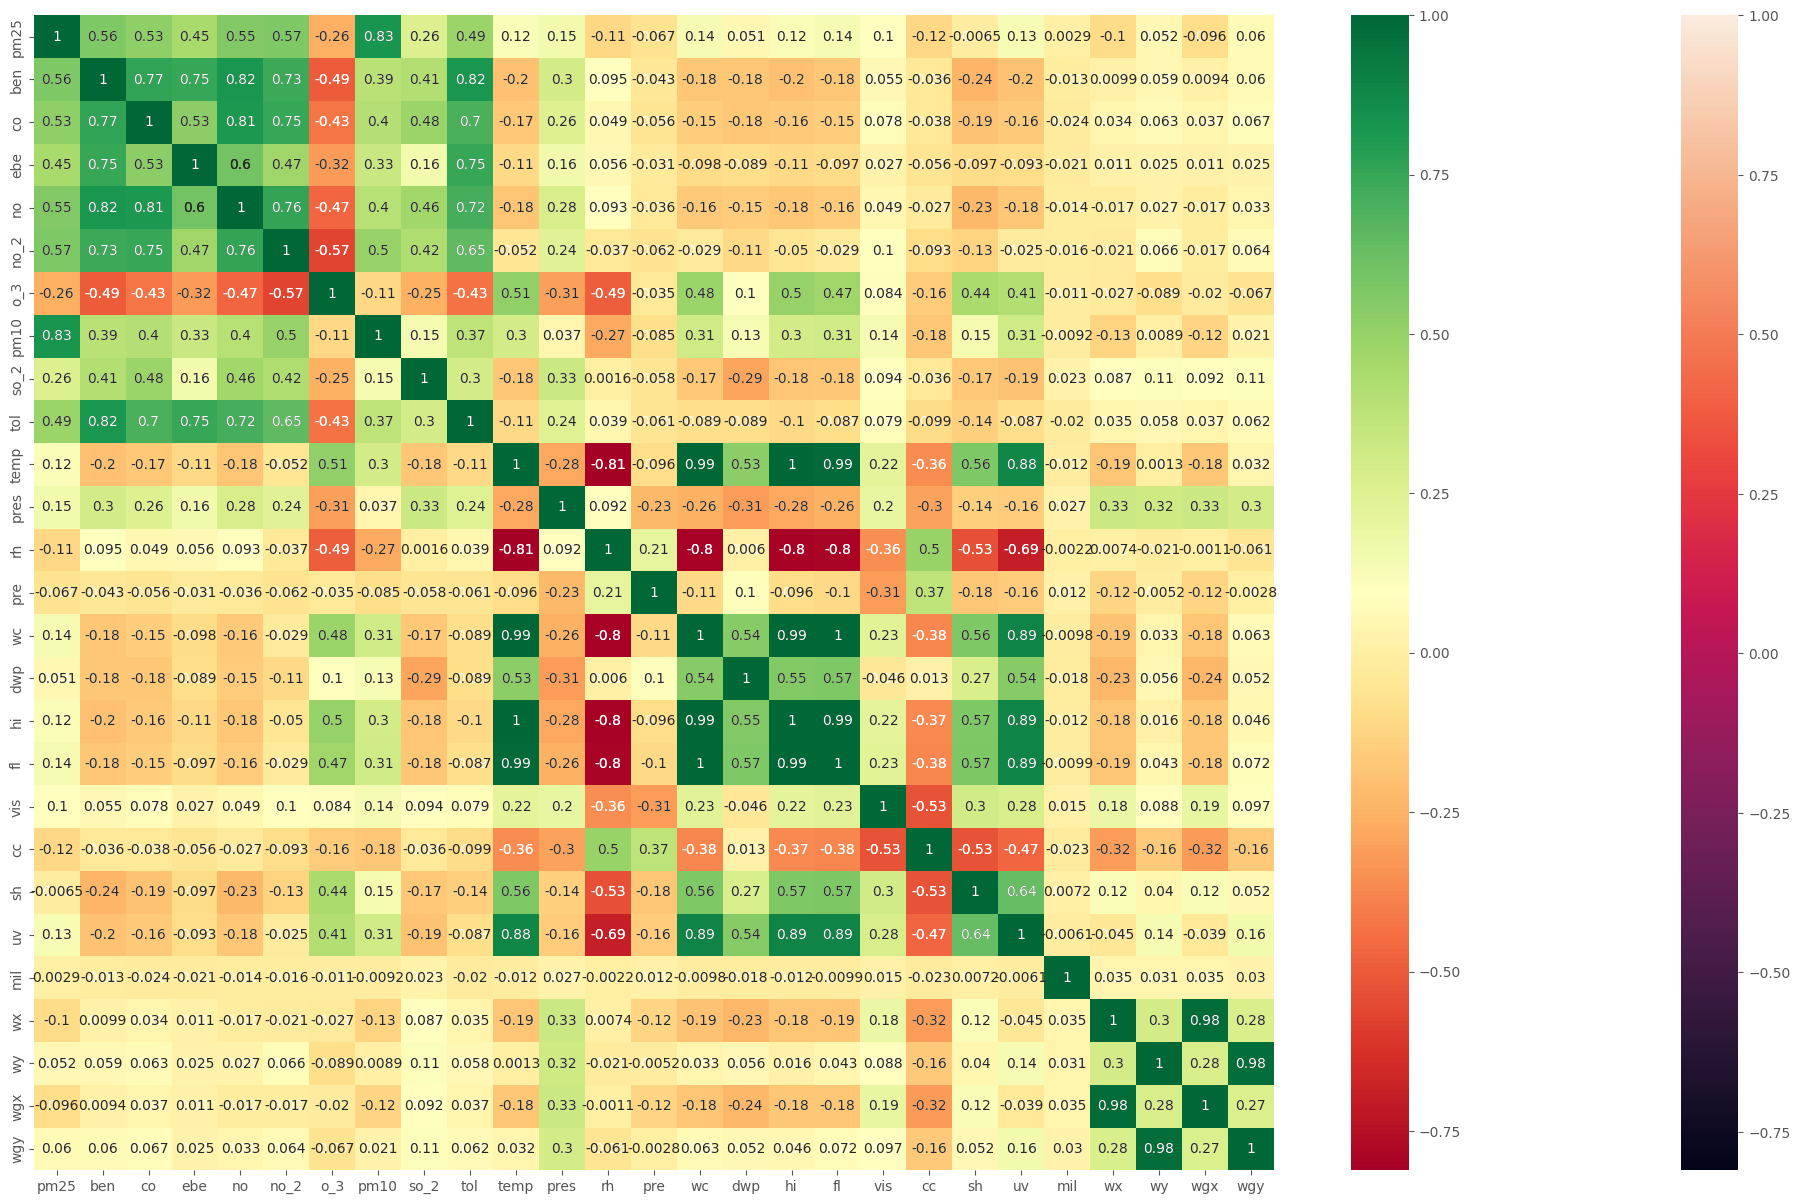

In [18]:
data = df2.iloc[:,:-5]
x = data.iloc[:, 1:]
y = data.iloc[:, 0]
corrMatrix = data.corr().round(decimals=2)
top_corr_features = corrMatrix.index

plt.figure(figsize=(25,15))
sns.heatmap(corrMatrix, annot=True)
sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
best_features = top_corr_features[corrMatrix.iloc[:,0].abs() >= 0.2]
print(list(best_features))

## *3.8* Data windowing and split

`The experiment is going to use the first 4 years of data for training, the 5th year for training validation and the last year for testing.`

In [19]:
# get the row number of the first oservation date time in 2017, which is going to be the split index
train_split = df2.index.get_loc('2017-01-01 00:00:00')
val_split = df2.index.get_loc('2016-01-01 00:00:00')
train_split, val_split

(43848, 35064)

`The dataset is going to be converted into a sliding window format as it follows:`

- samples of 48 steps of the 31 air pollutant and weather variables will predict the future 24 steps of the first column - PM2.5.
- time variables appended at the end of the dataset will also be windowed.
- the method "split_window_data" is going to perform both the dataset split into train and test data and the conversion into sliding windows.

In [20]:
"""
input: 
- the complete dataset in numpy array format: dataset
- the predicted variable: target_feature
- the sample length: steps_back
- the first index of the data partition to be windowed (default is 0): start_index
- the next after last index of the data partition to be windowed(default is None): end_index
- the length of the forecasting horizon (default is 0): steps_ahead 

output:
- numpy array containg windowed samples of the desired dataset partition
- numpy array containg target labels of the desired dataset partition
"""

def split_window_data(dataset, target_feature, steps_back,
                      start_index=0, end_index=None, steps_ahead=0):
    data = []
    labels = []

    start_index += steps_back
    if end_index is None:
      end_index = len(dataset) - steps_ahead
    if steps_ahead == 0:
      step = steps_ahead + 1
    else:
      step = steps_ahead

    for i in range(start_index, end_index, step):
      indices = range(i-steps_back, i)
      data.append(dataset[indices])

      if steps_ahead == 0:
          labels.append(target_feature[i+steps_ahead])
      else:
          labels.append(target_feature[i:i+steps_ahead])

    return np.array(data, dtype='float32'), np.array(labels, dtype='float32')

In [21]:
# choose the target feature to be predicted
target_feature = df2[['pm25', 't_y', 't_m', 't_wd', 't_d', 't_h']]

In [22]:
target_feature.head()

pm25  t_y  t_m  t_wd  t_d       t_h
date                                                        
2012-01-01 00:00:00  0.032558  0.0  0.0   1.0  0.0  0.000000
2012-01-01 01:00:00  0.306977  0.0  0.0   1.0  0.0  0.043478
2012-01-01 02:00:00  0.432558  0.0  0.0   1.0  0.0  0.086957
2012-01-01 03:00:00  0.381395  0.0  0.0   1.0  0.0  0.130435
2012-01-01 04:00:00  0.148837  0.0  0.0   1.0  0.0  0.173913

In [23]:
target_length = 12
sample_length = 4*target_length

### *3.8.1* Univariate data preparation (PM2.5 only)

In [24]:
"""
split train, validation and test data and arrange data points into
windows with sample_length look back steps and target_length steps ahead
"""

x_train_u, y_train_u = split_window_data(dataset=target_feature.to_numpy(),
                                    target_feature=target_feature.to_numpy(),
                                    end_index=val_split,
                                    steps_back=sample_length,
                                    steps_ahead=target_length)
x_val_u, y_val_u = split_window_data(dataset=target_feature.to_numpy(),
                                    target_feature=target_feature.to_numpy(),
                                    start_index=val_split,
                                    end_index=train_split,
                                    steps_back=sample_length,
                                    steps_ahead=target_length)
x_test_u, y_test_u = split_window_data(dataset=target_feature.to_numpy(),
                                target_feature=target_feature.to_numpy(),
                                start_index=train_split,
                                steps_back=sample_length,
                                steps_ahead=target_length)

In [25]:
# separate time features after windowing

x_train_u, tx_train_u = x_train_u[:,:,:-5], x_train_u[:,:,-5:]
x_val_u, tx_val_u = x_val_u[:,:,:-5], x_val_u[:,:,-5:]
x_test_u, tx_test_u = x_test_u[:,:,:-5], x_test_u[:,:,-5:]

y_train_u, ty_train_u = y_train_u[:,:,:-5], y_train_u[:,:,-5:]
y_val_u, ty_val_u = y_val_u[:,:,:-5], y_val_u[:,:,-5:]
y_test_u, ty_test_u = y_test_u[:,:,:-5], y_test_u[:,:,-5:]

In [26]:
x_train_u.shape, y_train_u.shape, x_val_u.shape, y_val_u.shape, x_test_u.shape, y_test_u.shape

((2918, 48, 1),
 (2918, 12, 1),
 (728, 48, 1),
 (728, 12, 1),
 (725, 48, 1),
 (725, 12, 1))

In [27]:
tx_train_u.shape, ty_train_u.shape, tx_val_u.shape, ty_val_u.shape, tx_test_u.shape, ty_test_u.shape

((2918, 48, 5),
 (2918, 12, 5),
 (728, 48, 5),
 (728, 12, 5),
 (725, 48, 5),
 (725, 12, 5))

### *3.8.2* Multivariate data preparation (pollutant and weather variables)

In [28]:
"""
split train, validation and test data and arrange data points into
windows with sample_length look back steps and target_length steps ahead
"""
x_train_m, y_train_m = split_window_data(dataset=df2.to_numpy(),
                                    target_feature=target_feature.to_numpy(),
                                    end_index=val_split,
                                    steps_back=sample_length,
                                    steps_ahead=target_length)
x_val_m, y_val_m = split_window_data(dataset=df2.to_numpy(),
                                    target_feature=target_feature.to_numpy(),
                                    start_index=val_split,
                                    end_index=train_split,
                                    steps_back=sample_length,
                                    steps_ahead=target_length)
x_test_m, y_test_m = split_window_data(dataset=df2.to_numpy(),
                                target_feature=target_feature.to_numpy(),
                                start_index=train_split,
                                steps_back=sample_length,
                                steps_ahead=target_length)

In [29]:
# separate time features after windowing

x_train_m, tx_train_m = x_train_m[:,:,:-5], x_train_m[:,:,-5:]
x_val_m, tx_val_m = x_val_m[:,:,:-5], x_val_m[:,:,-5:]
x_test_m, tx_test_m = x_test_m[:,:,:-5], x_test_m[:,:,-5:]

y_train_m, ty_train_m = y_train_m[:,:,:-5], y_train_m[:,:,-5:]
y_val_m, ty_val_m = y_val_m[:,:,:-5], y_val_m[:,:,-5:]
y_test_m, ty_test_m = y_test_m[:,:,:-5], y_test_m[:,:,-5:]

In [30]:
x_train_m.shape, y_train_m.shape, x_val_m.shape, y_val_m.shape, x_test_m.shape, y_test_m.shape

((2918, 48, 27),
 (2918, 12, 1),
 (728, 48, 27),
 (728, 12, 1),
 (725, 48, 27),
 (725, 12, 1))

In [31]:
tx_train_m.shape, ty_train_m.shape, tx_val_m.shape, ty_val_m.shape, tx_test_m.shape, ty_test_m.shape

((2918, 48, 5),
 (2918, 12, 5),
 (728, 48, 5),
 (728, 12, 5),
 (725, 48, 5),
 (725, 12, 5))

### *3.8.3* Multivariate data preparation (pollutant variables only)

In [32]:
"""
split train, validation and test data and arrange data points into
windows with sample_length look back steps and target_length steps ahead
"""
dataset=pd.concat([df2.iloc[:,:10], df2.iloc[:,-5:]], axis=1)

x_train_mp, y_train_mp = split_window_data(dataset=dataset.to_numpy(),
                                    target_feature=target_feature.to_numpy(),
                                    end_index=val_split,
                                    steps_back=sample_length,
                                    steps_ahead=target_length)
x_val_mp, y_val_mp = split_window_data(dataset=dataset.to_numpy(),
                                    target_feature=target_feature.to_numpy(),
                                    start_index=val_split,
                                    end_index=train_split,
                                    steps_back=sample_length,
                                    steps_ahead=target_length)
x_test_mp, y_test_mp = split_window_data(dataset=dataset.to_numpy(),
                                target_feature=target_feature.to_numpy(),
                                start_index=train_split,
                                steps_back=sample_length,
                                steps_ahead=target_length)

In [33]:
# separate time features after windowing

x_train_mp, tx_train_mp = x_train_mp[:,:,:-5], x_train_mp[:,:,-5:]
x_val_mp, tx_val_mp = x_val_mp[:,:,:-5], x_val_mp[:,:,-5:]
x_test_mp, tx_test_mp = x_test_mp[:,:,:-5], x_test_mp[:,:,-5:]

y_train_mp, ty_train_mp = y_train_mp[:,:,:-5], y_train_mp[:,:,-5:]
y_val_mp, ty_val_mp = y_val_mp[:,:,:-5], y_val_mp[:,:,-5:]
y_test_mp, ty_test_mp = y_test_mp[:,:,:-5], y_test_mp[:,:,-5:]

In [34]:
x_train_mp.shape, y_train_mp.shape, x_val_mp.shape, y_val_mp.shape, x_test_mp.shape, y_test_mp.shape

((2918, 48, 10),
 (2918, 12, 1),
 (728, 48, 10),
 (728, 12, 1),
 (725, 48, 10),
 (725, 12, 1))

In [35]:
tx_train_mp.shape, ty_train_mp.shape, tx_val_mp.shape, ty_val_mp.shape, tx_test_mp.shape, ty_test_mp.shape

((2918, 48, 5),
 (2918, 12, 5),
 (728, 48, 5),
 (728, 12, 5),
 (725, 48, 5),
 (725, 12, 5))

# *4.* Prediction Models

In [36]:
n_target_features = 1
n_time_features = 5
d_model = 64
dff = 256

## *4.1* Models definition

### *4.1.1* The Transformer models

- This experiment is going to test two different transformer implementations.   
<br>
- The first transformer model has been replicated from [Time-Series Forecasting GRU vs Transformers](https://www.kaggle.com/code/chanlilong/time-series-forecasting-gru-vs-transformers/notebook (xformer model), imported and initiated as shown below.   
<br>
- A second model has been adapted to time-series forecasting following the [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer#training) tutorial (made for natural language processing) and inspired by the following articles: [How to make a Transformer for time series forecasting with PyTorch](https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e) and [How to run inference with a PyTorch time series Transformer](https://towardsdatascience.com/how-to-run-inference-with-a-pytorch-time-series-transformer-394fd6cbe16c).   
<br>
- The xformer model replaces the Embedding layers (used for discrete sequential data - i.e. word embeddings) with TimeDistributed wrapped Linear Layers to be able to process continuous variables instead. The linear layers output size is equal to the chosen feature space size (d_model).   
<br>
- The second transformer model skips the Embedding layers as it hasn't been considered necessary because time series data is already vectorized. Instead, the original positional encoding, proposed by Vaswani et al. (2017) in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) has been replaced with a learnable time representation called Time2Vec and proposed by (Kazemi et al., 2019) in [Time2Vec: Learning a Vector Representation of Time](https://arxiv.org/abs/1907.05321). Time parameters are converted to a learned vectorial representation consisting of a feature capturing linear patterns and a selected number of periodic features. The time embedding layer output size is equal to the chosen feature space size (d_model).   
<br>
- Both transformer models are disregarding the d_model = 512 default value since it might be unnecessarily wide for the representation of the dataset.   
<br>
- Also, it is not advised to train long sequences with transformer models due to the O(n^2) complexity of the underlying Attention mechanism.   
<br>
- Both transformer models have been defined such as that the number of parameters closely matches the comparative models.

In [37]:
from models.kaggle_transformer import Transformer

def xformer_model(sample_length, target_length, n_features, n_target_features, num_layers, num_heads, dff, d_model, name):

    model = Transformer(n_target_features,num_layers=num_layers,num_heads=num_heads,dff=dff,d_model=d_model, name=name)
    inp, tar_inp = tf.random.normal((1,sample_length,n_features)),tf.random.normal((1,target_length,n_target_features))
    model(inp, tar_inp, False)
    model.compile()
    model.summary()
    return model

In [38]:
from models.t2v_transformer import T2V_Transformer

def t2v_transformer_model(sample_length, target_length, n_features, n_target_features, num_layers,
                        num_heads, dff, d_model, name, n_time_features=n_time_features, dropout_rate=0.1):

    model = T2V_Transformer(num_layers,num_heads,dff,n_time_features,
                            n_target_features,d_model,dropout_rate=dropout_rate,name=name)
    inp, tar_inp = tf.random.normal((1,sample_length,n_features+n_time_features)),tf.random.normal((1,target_length,n_target_features+n_time_features))
    model(inp, tar_inp, False)
    model.compile()
    model.summary()
    return model

### *4.1.2* The LSTM model

In [39]:
def lstm_model(sample_length, target_length, n_features, name):
    in1 = tf.keras.layers.Input((sample_length,n_features))
    lstm1 = tf.keras.layers.LSTM(256)(in1)
    lstm2 = tf.keras.layers.RepeatVector(target_length)(lstm1)
    lstm2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm2)
    lstm2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(lstm2)
    model = tf.keras.models.Model(in1,lstm2,name=name)
    model.compile()
    model.summary()
    return model

### *4.1.3* The CNN 1D model

In [40]:
def cnn1d_model(sample_length, target_length, n_features, name):
    in1 = tf.keras.layers.Input((sample_length,n_features))
    cnn1 = tf.keras.layers.Conv1D(24, 8, padding='same', activation='relu')(in1)
    cnn2 = tf.keras.layers.Flatten()(cnn1)
    cnn2 = tf.keras.layers.Dense(400, activation='relu')(cnn2)
    cnn2 = tf.keras.layers.Dense(100, activation='relu')(cnn2)
    cnn2 = tf.keras.layers.Dense(target_length)(cnn2)
    model = tf.keras.models.Model(in1,cnn2,name=name)
    model.compile()
    model.summary()
    return model

## *4.2* Build models

### *4.2.1* Univariate

In [41]:
sample_length = x_train_u.shape[1]
target_length = y_train_u.shape[1]
n_features = x_train_u.shape[-1]

In [42]:
sample_length, target_length, n_features

(48, 12, 1)

In [43]:
xformer_u = xformer_model(sample_length, target_length, n_features, n_target_features, num_layers=4, num_heads=2, dff=dff, d_model=d_model, name='xformer_u')

c:\Users\ursu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "xformer_u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  200064    
                                                                 
 decoder (Decoder)           multiple                  267136    
                                                                 
 dense_66 (Dense)            multiple                  65        
                                                                 
Total params: 467,265
Trainable params: 467,265
Non-trainable params: 0
_________________________________________________________________


In [44]:
t2v_trans_u = t2v_transformer_model(sample_length, target_length, n_features, n_target_features, num_layers=2, num_heads=4, dff=dff, d_model=d_model, name='t2v_trans_u')

Model: "t2v_trans_u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  202763    
                                                                 
 decoder_1 (Decoder)         multiple                  333487    
                                                                 
 dense_75 (Dense)            multiple                  65        
                                                                 
Total params: 536,315
Trainable params: 536,315
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstm_u = lstm_model(sample_length,target_length,n_features,'lstm_u')

Model: "lstm_u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 repeat_vector (RepeatVector  (None, 12, 256)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           197120    
                                                                 
 time_distributed_2 (TimeDis  (None, 12, 1)            129       
 tributed)                                                       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainabl

In [46]:
cnn1d_u = cnn1d_model(sample_length,target_length,n_features,name='cnn1d_u')

Model: "cnn1d_u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 24)            216       
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense_77 (Dense)            (None, 400)               461200    
                                                                 
 dense_78 (Dense)            (None, 100)               40100     
                                                                 
 dense_79 (Dense)            (None, 12)                1212      
                                                                 
Total params: 502,728
Trainable params: 502,728
Non-trainab

### *4.2.2* Multivariate (all parameters)

In [112]:
sample_length = x_train_m.shape[1]
target_length = y_train_m.shape[1]
n_features = x_train_m.shape[-1]

In [113]:
sample_length, target_length, n_features

(48, 12, 27)

In [116]:
xformer_m = xformer_model(sample_length, target_length, n_features, n_target_features, num_layers=4, num_heads=4, dff=dff, d_model=d_model, name='xformer_m')

Model: "xformer_m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_8 (Encoder)         multiple                  201728    
                                                                 
 decoder_8 (Decoder)         multiple                  267136    
                                                                 
 dense_388 (Dense)           multiple                  65        
                                                                 
Total params: 468,929
Trainable params: 468,929
Non-trainable params: 0
_________________________________________________________________


In [117]:
t2v_trans_m = t2v_transformer_model(sample_length, target_length, n_features, n_target_features, num_layers=2, num_heads=4, dff=dff, d_model=d_model, name='t2v_trans_m')

Model: "t2v_trans_m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_9 (Encoder)         multiple                  201385    
                                                                 
 decoder_9 (Decoder)         multiple                  333487    
                                                                 
 dense_397 (Dense)           multiple                  65        
                                                                 
Total params: 534,937
Trainable params: 534,937
Non-trainable params: 0
_________________________________________________________________


In [118]:
lstm_m = lstm_model(sample_length,target_length,n_features,'lstm_m')

Model: "lstm_m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 27)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               290816    
                                                                 
 repeat_vector_3 (RepeatVect  (None, 12, 256)          0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 12, 128)           197120    
                                                                 
 time_distributed_13 (TimeDi  (None, 12, 1)            129       
 stributed)                                                      
                                                                 
Total params: 488,065
Trainable params: 488,065
Non-trainabl

In [119]:
cnn1d_m = cnn1d_model(sample_length,target_length,n_features,name='cnn1d_m')

Model: "cnn1d_m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 27)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 24)            5208      
                                                                 
 flatten_5 (Flatten)         (None, 1152)              0         
                                                                 
 dense_399 (Dense)           (None, 400)               461200    
                                                                 
 dense_400 (Dense)           (None, 100)               40100     
                                                                 
 dense_401 (Dense)           (None, 12)                1212      
                                                                 
Total params: 507,720
Trainable params: 507,720
Non-trainab

In [120]:
in1 = tf.keras.layers.Input((sample_length,n_features,1))
cnn1 = tf.keras.layers.Conv2D(24, (1,2), padding='same', activation='relu')(in1)
cnn2 = tf.keras.layers.Conv2D(24, (8,1), padding='same', activation='relu')(cnn1)
cnn2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(cnn2)
cnn2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(cnn2)
cnn2 = tf.keras.layers.Flatten()(cnn2)
cnn2 = tf.keras.layers.Dense(250, activation='relu')(cnn2)
cnn2 = tf.keras.layers.Dense(100, activation='relu')(cnn2)
cnn2 = tf.keras.layers.Dense(target_length)(cnn2)
cnn2d_m = tf.keras.models.Model(in1,cnn2,name='cnn2d_m')
cnn2d_m.compile()
cnn2d_m.summary()

Model: "cnn2d_m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 27, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 27, 24)        72        
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 27, 24)        4632      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 13, 24)       0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 6, 24)        0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 1728)              0   

### *4.2.3* Multivariate (only pollutants)

In [54]:
sample_length = x_train_mp.shape[1]
target_length = y_train_mp.shape[1]
n_features = x_train_mp.shape[-1]

In [55]:
sample_length, target_length, n_features

(48, 12, 10)

In [56]:
xformer_mp = xformer_model(sample_length, target_length, n_features, n_target_features, num_layers=4, num_heads=4, dff=dff, d_model=d_model, name='xformer_mp')

Model: "xformer_mp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  200640    
                                                                 
 decoder_4 (Decoder)         multiple                  267136    
                                                                 
 dense_229 (Dense)           multiple                  65        
                                                                 
Total params: 467,841
Trainable params: 467,841
Non-trainable params: 0
_________________________________________________________________


In [57]:
t2v_trans_mp = t2v_transformer_model(sample_length, target_length, n_features, n_target_features, num_layers=2, num_heads=4, dff=dff, d_model=d_model, name='t2v_trans_mp')

Model: "t2v_trans_mp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  202286    
                                                                 
 decoder_5 (Decoder)         multiple                  333487    
                                                                 
 dense_238 (Dense)           multiple                  65        
                                                                 
Total params: 535,838
Trainable params: 535,838
Non-trainable params: 0
_________________________________________________________________


In [58]:
lstm_mp = lstm_model(sample_length,target_length,n_features,'lstm_mp')

Model: "lstm_mp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 10)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 256)               273408    
                                                                 
 repeat_vector_2 (RepeatVect  (None, 12, 256)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 12, 128)           197120    
                                                                 
 time_distributed_8 (TimeDis  (None, 12, 1)            129       
 tributed)                                                       
                                                                 
Total params: 470,657
Trainable params: 470,657
Non-trainab

In [59]:
cnn1d_mp = cnn1d_model(sample_length,target_length,n_features,name='cnn1d_mp')

Model: "cnn1d_mp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 10)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 24)            1944      
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_240 (Dense)           (None, 400)               461200    
                                                                 
 dense_241 (Dense)           (None, 100)               40100     
                                                                 
 dense_242 (Dense)           (None, 12)                1212      
                                                                 
Total params: 504,456
Trainable params: 504,456
Non-traina

In [60]:
in1 = tf.keras.layers.Input((sample_length,n_features,1))
cnn1 = tf.keras.layers.Conv2D(24, (1,2), padding='same', activation='relu')(in1)
cnn2 = tf.keras.layers.Conv2D(24, (8,1), padding='same', activation='relu')(cnn1)
cnn2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(cnn2)
cnn2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(cnn2)
cnn2 = tf.keras.layers.Flatten()(cnn2)
cnn2 = tf.keras.layers.Dense(700, activation='relu')(cnn2)
cnn2 = tf.keras.layers.Dense(100, activation='relu')(cnn2)
cnn2 = tf.keras.layers.Dense(target_length)(cnn2)
cnn2d_mp = tf.keras.models.Model(in1,cnn2,name='cnn2d_mp')
cnn2d_mp.compile()
cnn2d_mp.summary()

Model: "cnn2d_mp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 10, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 10, 24)        72        
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 10, 24)        4632      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 5, 24)        0         
 2D)                                                             
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 2, 24)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 576)               0  

# *5.* Train models

- Learning rate custom scheduler, used for transformer models has been taken over from [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer#training).

In [61]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, coef=-1.5):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.coef = coef

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** self.coef)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)
learning_rate1 = CustomSchedule(d_model, coef=-1.1)

optimizer1 = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
optimizer2 = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98,epsilon=1e-9)
optimizer3 = tf.keras.optimizers.Adam(learning_rate1, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [62]:
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

mse = MeanSquaredError(name='mse')
rmse = RootMeanSquaredError(name='rmse')

# instantiate metrics for each model
train_metric_1 = RootMeanSquaredError(name='rmse')
val_metric_1 = RootMeanSquaredError(name='rmse')
train_metric_2 = RootMeanSquaredError(name='rmse')
val_metric_2 = RootMeanSquaredError(name='rmse')
train_metric_3 = RootMeanSquaredError(name='rmse')
val_metric_3 = RootMeanSquaredError(name='rmse')
train_metric_4 = RootMeanSquaredError(name='rmse')
val_metric_4 = RootMeanSquaredError(name='rmse')
train_metric_5 = RootMeanSquaredError(name='rmse')
val_metric_5 = RootMeanSquaredError(name='rmse')

`The training will be performed for 200 iterations`
- In the original implementation the transformer model requires a "start" token.
- For the current experiment the "Start" token will be the value of the predicted variable corresponding to the last timestep of the input sequence.

In [63]:
epochs = 200

def train_models(models, data, time_data, val_data, time_val_data, len_data, epochs, univariate=False, loss=mse, metrics=[rmse]):

    history={}
    for model in models:
        history[model.name] = {'train':{'loss': {}, 'metrics': {}}, 'val':{'loss': {}, 'metrics': {}}}
        for i in history[model.name].keys():
            history[model.name][i]['loss'][mse.name] = []
            for metric in metrics:
                history[model.name][i]['metrics'][metric.name] = []

    for e in range(epochs):

        for i, batch in enumerate(zip(data, time_data)):

            if i<len_data-1:
                inp, tar = batch[0]
                inp_time, tar_time = batch[1]

                # tar = tf.expand_dims(tar,-1)

                # tar_inp = tf.ones((batch_size,1,n_target_features))*-0.1
                tar_inp = inp[:,-1,0]
                tar_inp = tf.expand_dims(tar_inp,-1)
                tar_inp = tf.expand_dims(tar_inp,-1)
                tar_inp_time = inp_time[:,-1,:]
                tar_inp_time = tf.expand_dims(tar_inp_time,1)
                tar_inp = tf.concat([tar_inp, tar_inp_time],-1)
                tar_inp1 = tar[:,:-1]
                tar_inp1_time = tar_time[:,:-1]
                tar_inp1 = tf.concat([tar_inp1, tar_inp1_time],-1)

                tar_inp = tf.concat([tar_inp, tar_inp1],1)

                in_xform = inp[:, :, :]
                tar_inp_xform = tf.expand_dims(tar_inp[:, :, 0],-1)

                in_trans = tf.concat([inp, inp_time],-1)
                tar_inp_trans = tar_inp

                tar_real = tar[:, :, :]

                with tf.GradientTape() as tape:
                    pred1 = models[0](in_xform, tar_inp_xform,training=True)
                    train_loss1 = mse(tar_real,pred1)
                gradients1 = tape.gradient(train_loss1, models[0].trainable_variables)
                optimizer1.apply_gradients(zip(gradients1, models[0].trainable_variables))
                train_metric_1.update_state(tar_real,pred1)

                with tf.GradientTape() as tape:
                    pred2 = models[1](in_trans, tar_inp_trans, training=True)
                    train_loss2 = mse(tar_real,pred2)
                gradients2 = tape.gradient(train_loss2, models[1].trainable_variables)
                optimizer3.apply_gradients(zip(gradients2, models[1].trainable_variables))
                train_metric_2.update_state(tar_real,pred2)

                with tf.GradientTape() as tape:
                    pred3 = models[2](inp)
                    train_loss3 = mse(tar,pred3)
                gradients3 = tape.gradient(train_loss3, models[2].trainable_variables)
                optimizer2.apply_gradients(zip(gradients3, models[2].trainable_variables))
                train_metric_3.update_state(tar,pred3)

                with tf.GradientTape() as tape:
                    pred4 = models[3](inp)
                    train_loss4 = mse(tar,pred4)
                gradients4 = tape.gradient(train_loss4, models[3].trainable_variables)
                optimizer2.apply_gradients(zip(gradients4, models[3].trainable_variables))
                train_metric_4.update_state(tar,pred4)

                if univariate==False:
                    with tf.GradientTape() as tape:
                        pred5 = models[4](inp)
                        train_loss5 = mse(tar,pred5)
                    gradients5 = tape.gradient(train_loss5, models[4].trainable_variables)
                    optimizer2.apply_gradients(zip(gradients5, models[4].trainable_variables))
                    train_metric_5.update_state(tar,pred5)
       
        train_metric_1_res = train_metric_1.result()
        train_metric_2_res = train_metric_2.result()
        train_metric_3_res = train_metric_3.result()
        train_metric_4_res = train_metric_4.result()

        loss_list = [train_loss1, train_loss2, train_loss3, train_loss4]
        acc_list = [train_metric_1_res, train_metric_2_res, train_metric_3_res, train_metric_4_res]

        if univariate==False:
            train_metric_5_res = train_metric_5.result()
            loss_list.append(train_loss5)
            acc_list.append(train_metric_5_res)
            train_metric_5.reset_states()
        
        for i,model in enumerate(models):
            history[model.name]['train']['loss']['mse'].append(loss_list[i])
            history[model.name]['train']['metrics']['rmse'].append(acc_list[i])

        train_metric_1.reset_states()
        train_metric_2.reset_states()
        train_metric_3.reset_states()
        train_metric_4.reset_states()
        
        for i, batch in enumerate(zip(val_data, time_val_data)):

            if i<len_data-1:
                inp, tar = batch[0]
                inp_time, tar_time = batch[1]

                # tar = tf.expand_dims(tar,-1)

                # tar_inp = tf.ones((batch_size,1,n_target_features))*-0.1
                tar_inp = inp[:,-1,0]
                tar_inp = tf.expand_dims(tar_inp,-1)
                tar_inp = tf.expand_dims(tar_inp,-1)
                tar_inp_time = inp_time[:,-1,:]
                tar_inp_time = tf.expand_dims(tar_inp_time,1)
                tar_inp = tf.concat([tar_inp, tar_inp_time],-1)

                tar_inp1 = tar[:,:-1]
                tar_inp1_time = tar_time[:,:-1]
                tar_inp1 = tf.concat([tar_inp1, tar_inp1_time],-1)

                tar_inp = tf.concat([tar_inp, tar_inp1],1)

                in_xform = inp[:, :, :]
                tar_inp_xform = tf.expand_dims(tar_inp[:, :, 0],-1)

                in_trans = tf.concat([inp, inp_time],-1)
                tar_inp_trans = tar_inp

                tar_real = tar[:, :, :]

                pred1_val = models[0](in_xform, tar_inp_xform,training=False)
                val_loss1 = mse(tar_real,pred1_val)
                pred2_val = models[1](in_trans, tar_inp_trans, training=False)
                val_loss2 = mse(tar_real,pred2_val)
                pred3_val = models[2](inp, training=False)
                val_loss3 = mse(tar,pred3_val)
                pred4_val = models[3](inp, training=False)
                val_loss4 = mse(tar,pred4_val)
                if univariate==False:
                    pred5_val = models[4](inp, training=False)
                    val_loss5 = mse(tar,pred5_val)
                val_metric_1.update_state(tar,pred1_val)
                val_metric_2.update_state(tar,pred2_val)
                val_metric_3.update_state(tar,pred3_val)
                val_metric_4.update_state(tar,pred4_val)
                if univariate==False:
                    val_metric_5.update_state(tar,pred5_val)
        val_metric_1_res = val_metric_1.result()
        val_metric_2_res = val_metric_2.result()
        val_metric_3_res = val_metric_3.result()
        val_metric_4_res = val_metric_4.result()

        val_loss_list = [val_loss1, val_loss2, val_loss3, val_loss4]
        val_metric_list = [val_metric_1_res, val_metric_2_res, val_metric_3_res, val_metric_4_res]
        if univariate==False:
            val_metric_5_res = val_metric_5.result()
            val_loss_list.append(val_loss5)
            val_metric_list.append(val_metric_5_res)
            val_metric_5.reset_states() 
        
        for i,model in enumerate(models):
                history[model.name]['val']['loss']['mse'].append(val_loss_list[i])
                history[model.name]['val']['metrics']['rmse'].append(val_metric_list[i])

        val_metric_1.reset_states()
        val_metric_2.reset_states()
        val_metric_3.reset_states()
        val_metric_4.reset_states()

        print(f"Epoch {e+1}     Xformer | train_loss: {train_loss1.numpy()}, train_{train_metric_1.name}: {train_metric_1_res}, val_loss: {val_loss1.numpy()}, val_{val_metric_1.name}: {val_metric_1_res}\n\
            T2V Transformer | train_loss: {train_loss2.numpy()}, train_{train_metric_2.name}: {train_metric_2_res}, val_loss: {val_loss2.numpy()}, val_{val_metric_2.name}: {val_metric_2_res}\n\
            LSTM | train_loss: {train_loss3.numpy()}, train_{train_metric_3.name}: {train_metric_3_res}, val_loss: {val_loss3.numpy()}, val_{val_metric_3.name}: {val_metric_3_res}\n\
            1D CNN | train_loss: {train_loss4.numpy()}, train_{train_metric_4.name}: {train_metric_4_res}, val_loss: {val_loss4.numpy()}, val_{val_metric_4.name}: {val_metric_4_res}")
        if univariate==False:
            print(f"            2D CNN | train_loss: {train_loss5.numpy()}, train_{train_metric_5.name}: {train_metric_5_res}, val_loss: {val_loss5.numpy()}, val_{val_metric_5.name}: {val_metric_5_res}\n")

    return history

In [64]:
# function to plot train and validation losses

def plot_history(train_history, val_history, title):

    epochs = range(len(train_history))

    plt.figure(figsize=(7,5))

    plt.plot(epochs, train_history, 'b', label='Training loss')
    plt.plot(epochs, val_history, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

`The custom predict functions only apply to transformer models, as they require a second input - the right shifted previously predicted values.`

In [65]:
def predict_xformer(inp, model, sample_length, target_length, n_features):
    
    inp = inp.reshape(-1,sample_length,n_features)
    start = inp[:,-1,0]
    while len(start.shape) < len(inp.shape):
        start = tf.expand_dims(start,-1)

    for i in range(target_length):
        pred = model(inp,start,training=False)
        pred = np.expand_dims(pred[:,-1,:],0)
        start = np.concatenate([start,pred],axis=1)
        
    return start[:,1:]

`The predict function for time2vec transformer is slightly different as every input needs to also include time features for temporal position embedding.`

In [66]:
def predict_t2v(inp, inp_time, out_time, model, sample_length, target_length, n_features, n_time_features):
    
    inp = inp.reshape(-1,sample_length,n_features)
    inp_time = inp_time.reshape(-1,sample_length,n_time_features)
    inp = np.concatenate([inp, inp_time], axis=-1)
    out_time = out_time.reshape(-1,target_length,n_time_features)
#     inp = tf.reshape(inp,(-1,24,4))
    n_batch = inp.shape[0]
    # start = np.ones((n_batch,1,n_target_features+5))*-0.1
    start = inp[:,-1,0]
    while len(start.shape) < len(inp.shape):
        start = tf.expand_dims(start,-1)
    start_time = inp_time[:,-1,:]
    start_time = tf.expand_dims(start_time,1)
    start = tf.concat([start, start_time], axis=-1)
    # print('input:', inp.shape)
    # print('initial start:', start.shape)
    for i in range(target_length):
        pred = model(inp,start,training=False)
        # print('pred 1 at iter {}'.format(i+1), pred.shape)
        pred = np.expand_dims(pred[:,-1,0],-1)
        pred = np.expand_dims(pred,0)
        pred_time = np.expand_dims(out_time[:,i,:], axis=1)
        # print(pred.shape, pred_time.shape)
        pred = np.concatenate([pred, pred_time], axis=-1)
        # print('pred 2 at iter {}'.format(i+1), pred.shape)
        start = np.concatenate([start,pred],axis=1)
        # print('updated start after iter {}'.format(i+1), pred.shape)
        # print(start.shape)
        
    return start[:,1:,0]

In [121]:
batch_size = 128

## *5.1* Univariate

`The train and test datasets will be prepared for training and validation as it follows:`

- the samples will be mapped to their corresponding target labels using the tensorflow.data.Dataset.from_tensor_slices method.
- the obtained (sample, label) slices will be then stacked into "batch_size" long batches.

In [68]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_u, y_train_u))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((x_val_u, y_val_u))
val_data = val_data.batch(batch_size)

`Similarly, time data will be organized into batches:`

In [69]:
train_data_time = tf.data.Dataset.from_tensor_slices((tx_train_u, ty_train_u))
train_data_time = train_data_time.batch(batch_size)

val_data_time = tf.data.Dataset.from_tensor_slices((tx_val_u, ty_val_u))
val_data_time = val_data_time.batch(batch_size)

In [70]:
len_data = sum(1 for _ in train_data)
len_val_data = sum(1 for _ in val_data)
len_data, len_val_data

(23, 6)

In [122]:
models = [xformer_u, t2v_trans_u, lstm_u, cnn1d_u]
model_names = ['Xformer', 'T2V Transformer', 'LSTM', '1D CNN', '2D CNN']

In [72]:
history_u = train_models(models, train_data, train_data_time, val_data, val_data_time, len_data, epochs, univariate=True)

Epoch 1     Xformer | train_loss: 0.266126424074173, train_rmse: 0.6968441009521484, val_loss: 0.03409578651189804, val_rmse: 0.17628981173038483
            T2V Transformer | train_loss: 1.9752386808395386, train_rmse: 1.4122508764266968, val_loss: 0.4519253671169281, val_rmse: 1.5593934059143066
            LSTM | train_loss: 0.0012976010330021381, train_rmse: 0.03906738758087158, val_loss: 0.0025394796393811703, val_rmse: 0.040050867944955826
            1D CNN | train_loss: 0.0009991528932005167, train_rmse: 0.03859950229525566, val_loss: 0.0020644129253923893, val_rmse: 0.03832258656620979
Epoch 2     Xformer | train_loss: 0.25229254364967346, train_rmse: 0.5281803011894226, val_loss: 0.02514059841632843, val_rmse: 0.1631881296634674
            T2V Transformer | train_loss: 0.19800527393817902, train_rmse: 0.7012444138526917, val_loss: 0.035681769251823425, val_rmse: 0.30126404762268066
            LSTM | train_loss: 0.0011598519049584866, train_rmse: 0.03362993150949478, val_los

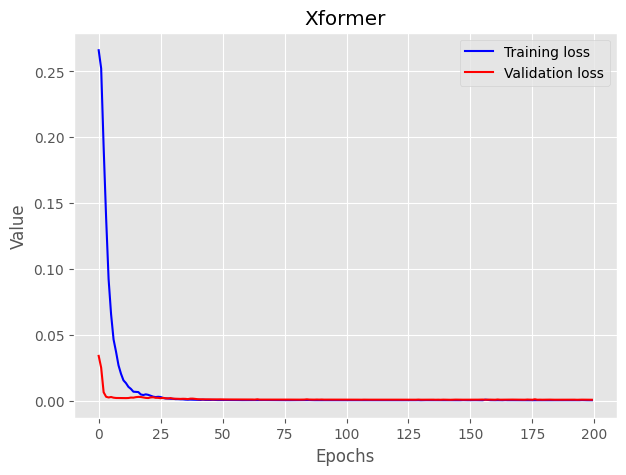

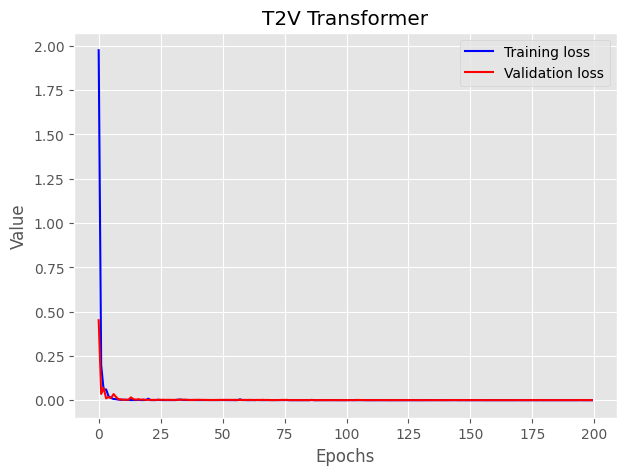

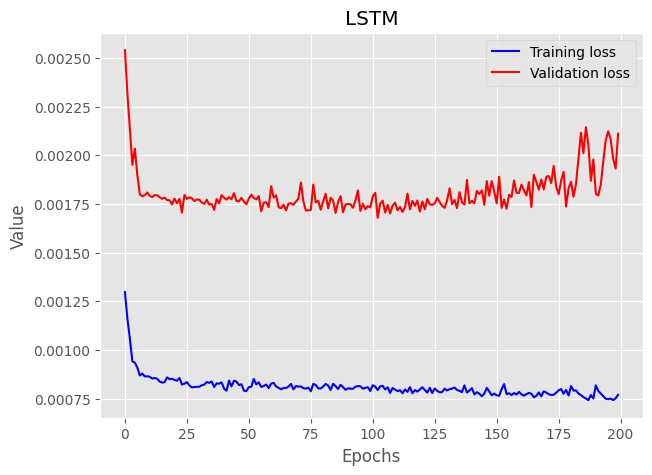

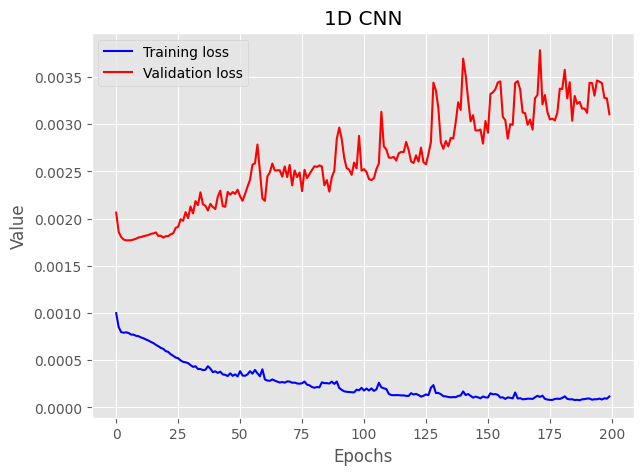

In [73]:
for i,model in enumerate(models):
    train_history = history_u[model.name]['train']['loss']['mse']
    val_history = history_u[model.name]['val']['loss']['mse']
    plot_history(train_history=train_history, val_history=val_history, title=f"{model_names[i]}")

In [74]:
preds_xform_u = [predict_xformer(x,xformer_u, x_test_u.shape[1], y_test_u.shape[1], x_test_u.shape[-1]) for x in x_test_u]

In [75]:
preds_t2v_trans_u = [predict_t2v(x,y,z,t2v_trans_u, x_test_u.shape[1], y_test_u.shape[1], x_test_u.shape[-1], tx_test_u.shape[-1]) for x,y,z in zip(x_test_u, tx_test_u, ty_test_u)]

In [76]:
preds_lstm_u = lstm_u.predict(x_test_u)

23/23 [==============================] - 1s 10ms/step


In [77]:
preds_cnn1d_u = cnn1d_u.predict(x_test_u)

23/23 [==============================] - 0s 4ms/step


## *5.2* Multivariate

In [123]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_m, y_train_m))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((x_val_m, y_val_m))
val_data = val_data.batch(batch_size)

In [124]:
train_data_time = tf.data.Dataset.from_tensor_slices((tx_train_m, ty_train_m))
train_data_time = train_data_time.batch(batch_size)

val_data_time = tf.data.Dataset.from_tensor_slices((tx_val_m, ty_val_m))
val_data_time = val_data_time.batch(batch_size)

In [125]:
len_data = sum(1 for _ in train_data)
len_val_data = sum(1 for _ in val_data)
len_data, len_val_data

(23, 6)

In [126]:
models = [xformer_m, t2v_trans_m, lstm_m, cnn1d_m, cnn2d_m]

In [127]:
history_m = train_models(models, train_data, train_data_time, val_data, val_data_time, len_data, epochs)

Epoch 1     Xformer | train_loss: 0.04303130507469177, train_rmse: 1.2733253240585327, val_loss: 0.013332456350326538, val_rmse: 0.09281820058822632
            T2V Transformer | train_loss: 0.2699839770793915, train_rmse: 1.033954381942749, val_loss: 0.33881837129592896, val_rmse: 0.5214501619338989
            LSTM | train_loss: 0.0014086050214245915, train_rmse: 0.1032179743051529, val_loss: 0.0035013421438634396, val_rmse: 0.04852508008480072
            1D CNN | train_loss: 0.0015330114401876926, train_rmse: 0.0939677283167839, val_loss: 0.0028683943673968315, val_rmse: 0.04492604732513428
            2D CNN | train_loss: 0.0011568452464416623, train_rmse: 0.04769333451986313, val_loss: 0.0024230366107076406, val_rmse: 0.04318195581436157

Epoch 2     Xformer | train_loss: 0.04574985429644585, train_rmse: 0.25106462836265564, val_loss: 0.020500730723142624, val_rmse: 0.1244514137506485
            T2V Transformer | train_loss: 0.04630982503294945, train_rmse: 0.2950446903705597, v

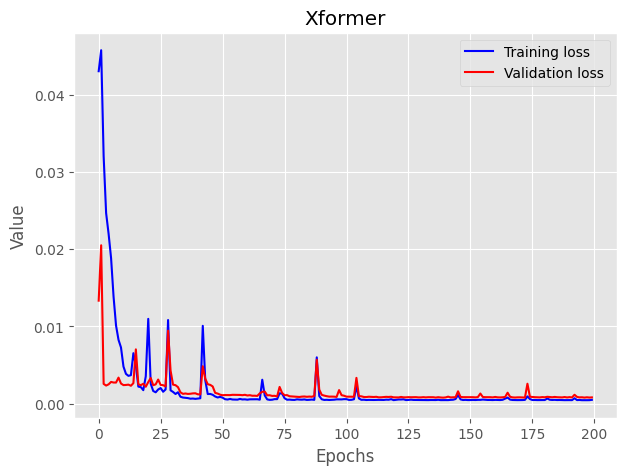

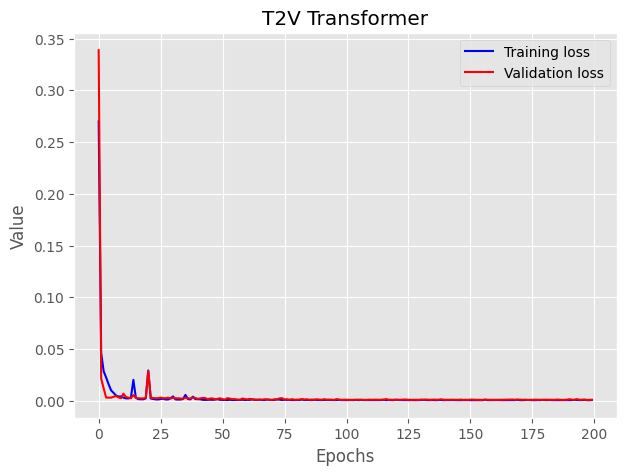

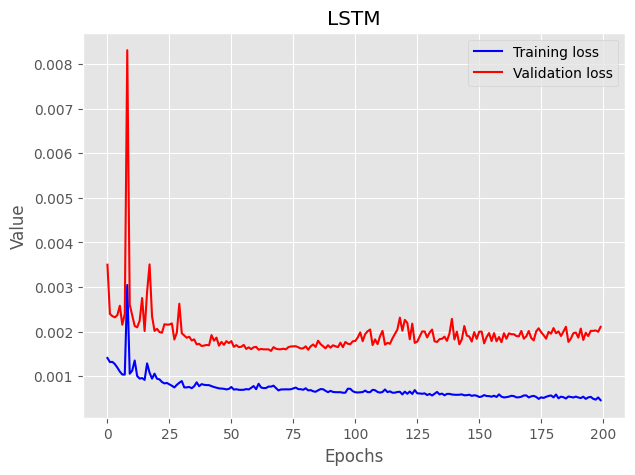

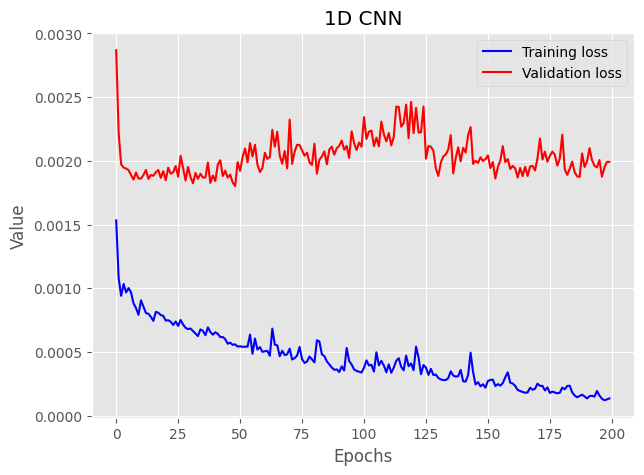

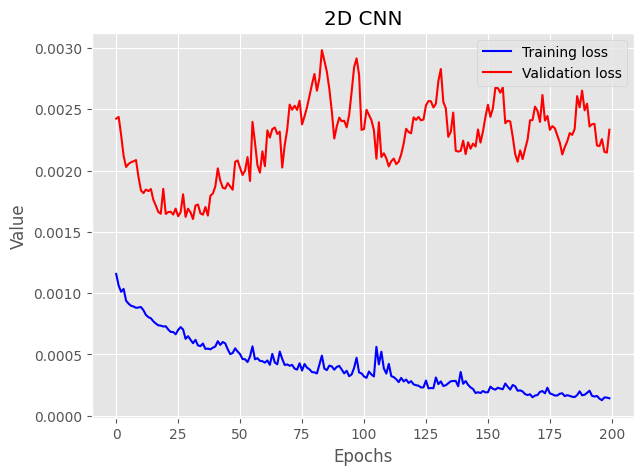

In [128]:
for i,model in enumerate(models):
    train_history = history_m[model.name]['train']['loss']['mse']
    val_history = history_m[model.name]['val']['loss']['mse']
    plot_history(train_history=train_history, val_history=val_history, title=f"{model_names[i]}")

In [129]:
preds_xform_m = [predict_xformer(x,xformer_m, x_test_m.shape[1], y_test_m.shape[1], x_test_m.shape[-1]) for x in x_test_m]

In [130]:
preds_t2v_trans_m = [predict_t2v(x,y,z,t2v_trans_m, x_test_m.shape[1], y_test_m.shape[1], x_test_m.shape[-1], tx_test_m.shape[-1]) for x,y,z in zip(x_test_m, tx_test_m, ty_test_m)]

In [131]:
preds_lstm_m = lstm_m.predict(x_test_m)

23/23 [==============================] - 1s 13ms/step


In [132]:
preds_cnn1d_m = cnn1d_m.predict(x_test_m)

23/23 [==============================] - 0s 4ms/step


In [133]:
preds_cnn2d_m = cnn2d_m.predict(x_test_m)

23/23 [==============================] - 0s 4ms/step


## *5.3* Multivariate (pollutants only)

In [89]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_mp, y_train_mp))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((x_val_mp, y_val_mp))
val_data = val_data.batch(batch_size)

In [90]:
train_data_time = tf.data.Dataset.from_tensor_slices((tx_train_mp, ty_train_mp))
train_data_time = train_data_time.batch(batch_size)

val_data_time = tf.data.Dataset.from_tensor_slices((tx_val_mp, ty_val_mp))
val_data_time = val_data_time.batch(batch_size)

In [91]:
len_data = sum(1 for _ in train_data)
len_val_data = sum(1 for _ in val_data)

In [92]:
models = [xformer_mp, t2v_trans_mp, lstm_mp, cnn1d_mp, cnn2d_mp]

In [93]:
history_mp = train_models(models, train_data, train_data_time, val_data, val_data_time, len_data, epochs)

Epoch 1     Xformer | train_loss: 0.20751984417438507, train_rmse: 1.4337186813354492, val_loss: 0.1819874495267868, val_rmse: 0.4089154899120331
            T2V Transformer | train_loss: 0.12720860540866852, train_rmse: 1.1202547550201416, val_loss: 0.23500055074691772, val_rmse: 0.3688424825668335
            LSTM | train_loss: 0.0020561309065669775, train_rmse: 0.05031090974807739, val_loss: 0.0034586654510349035, val_rmse: 0.051203012466430664
            1D CNN | train_loss: 0.0011069693136960268, train_rmse: 0.051181305199861526, val_loss: 0.0024102330207824707, val_rmse: 0.0411018468439579
            2D CNN | train_loss: 0.0011090998305007815, train_rmse: 0.03884220868349075, val_loss: 0.0021831602789461613, val_rmse: 0.04036574810743332

Epoch 2     Xformer | train_loss: 0.05585620924830437, train_rmse: 0.3133088946342468, val_loss: 0.003100431989878416, val_rmse: 0.04504995420575142
            T2V Transformer | train_loss: 0.06539551913738251, train_rmse: 0.3260316252708435,

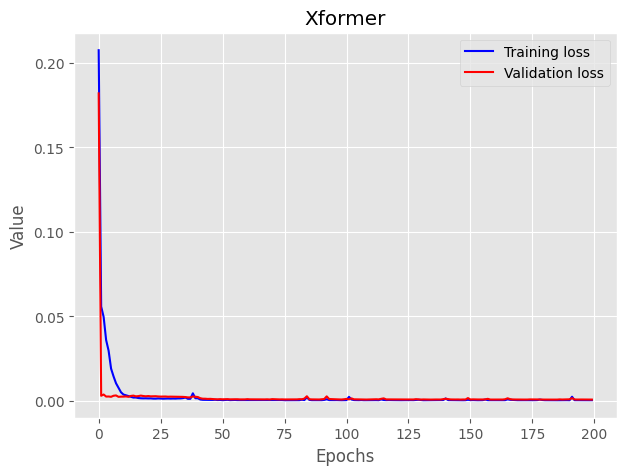

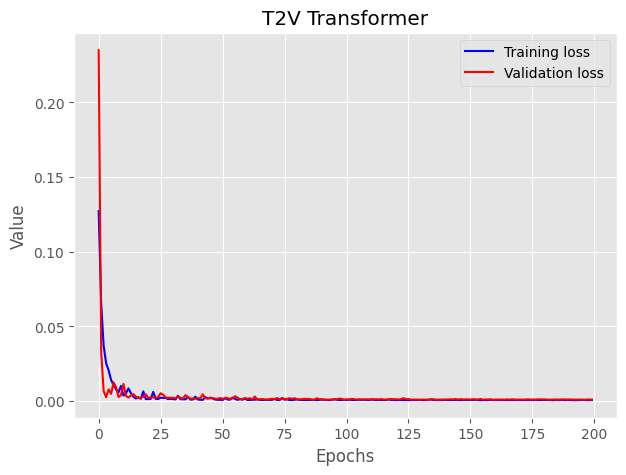

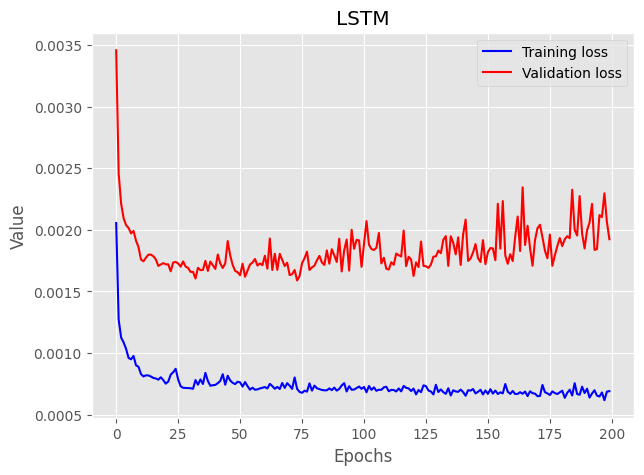

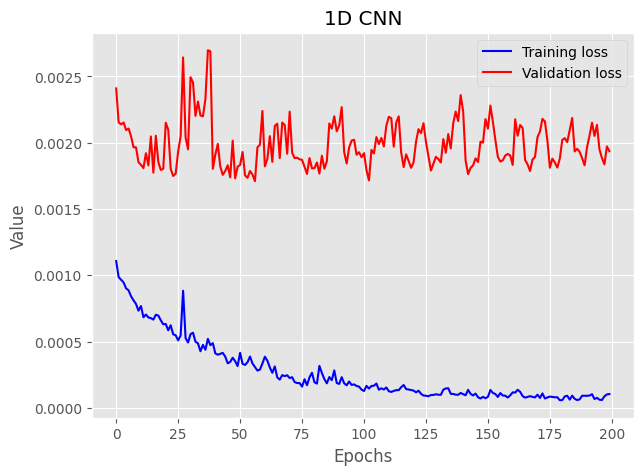

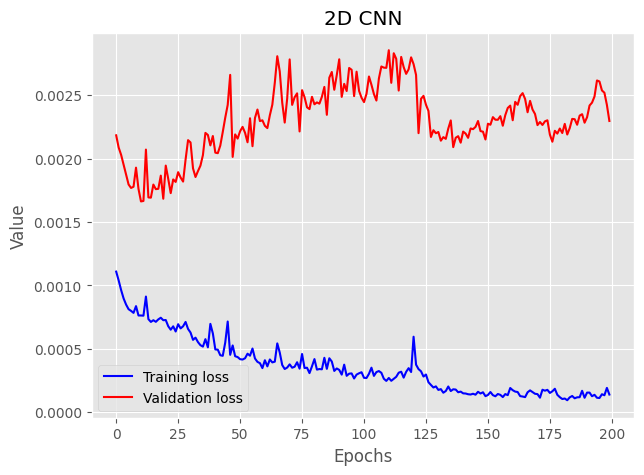

In [94]:
for i,model in enumerate(models):
    train_history = history_mp[model.name]['train']['loss']['mse']
    val_history = history_mp[model.name]['val']['loss']['mse']
    plot_history(train_history=train_history, val_history=val_history, title=f"{model_names[i]}")

In [95]:
preds_xform_mp = [predict_xformer(x,xformer_mp, x_test_mp.shape[1], y_test_mp.shape[1], x_test_mp.shape[-1]) for x in x_test_mp]

In [96]:
preds_t2v_trans_mp = [predict_t2v(x,y,z,t2v_trans_mp, x_test_mp.shape[1], y_test_mp.shape[1], x_test_mp.shape[-1], tx_test_mp.shape[-1]) for x,y,z in zip(x_test_mp, tx_test_mp, ty_test_mp)]

In [97]:
preds_lstm_mp = lstm_mp.predict(x_test_mp)

23/23 [==============================] - 2s 9ms/step


In [98]:
preds_cnn1d_mp = cnn1d_mp.predict(x_test_mp)

23/23 [==============================] - 0s 4ms/step


In [99]:
preds_cnn2d_mp = cnn2d_mp.predict(x_test_mp)

23/23 [==============================] - 0s 6ms/step


# *6.* Plot Predictions

In [100]:
# sample visualization of predicted against expected

def data_plot(true_future, prediction, model):
    fig,ax=plt.subplots(figsize=(20, 6))
    ax.set_title(f"{model}")
    ax.set_xlabel('Datetime')
    ax.set_ylabel('μg/m³')
    x = df2[train_split+sample_length:-target_length].index
    ax.plot(x, true_future, '-bo', label='Expected')
    if prediction.any():
        ax.plot(x, prediction, '-ro', label='Predicted')
    ax.set(xlim=(x[0], x[504]))
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

In [101]:
# denormalize true data
y_test_u_den = scaler_pm25.inverse_transform(y_test_u.reshape(-1,n_target_features))
y_test_m_den = scaler_pm25.inverse_transform(y_test_m.reshape(-1,n_target_features))
y_test_mp_den = scaler_pm25.inverse_transform(y_test_mp.reshape(-1,n_target_features))

In [134]:
# change Transformer models predictions into numpy arrays

preds_xform1 = [preds_xform_u[i].squeeze(axis=0) for i in range(len(preds_xform_u))]
preds_xform1 = np.array(preds_xform1).squeeze(axis=-1)
preds_t2v_trans1 = [preds_t2v_trans_u[i].squeeze(axis=0) for i in range(len(preds_t2v_trans_u))]
preds_t2v_trans1 = np.array(preds_t2v_trans1)

preds_xform2 = [preds_xform_m[i].squeeze(axis=0) for i in range(len(preds_xform_m))]
preds_xform2 = np.array(preds_xform2).squeeze(axis=-1)
preds_t2v_trans2 = [preds_t2v_trans_m[i].squeeze(axis=0) for i in range(len(preds_t2v_trans_m))]
preds_t2v_trans2 = np.array(preds_t2v_trans2)

preds_xform3 = [preds_xform_mp[i].squeeze(axis=0) for i in range(len(preds_xform_mp))]
preds_xform3 = np.array(preds_xform3).squeeze(axis=-1)
preds_t2v_trans3 = [preds_t2v_trans_mp[i].squeeze(axis=0) for i in range(len(preds_t2v_trans_mp))]
preds_t2v_trans3 = np.array(preds_t2v_trans3)

In [135]:
# denormalize predictions

preds_xform1_den = scaler_pm25.inverse_transform(preds_xform1.reshape(-1,n_target_features))
preds_xform2_den = scaler_pm25.inverse_transform(preds_xform2.reshape(-1,n_target_features))
preds_xform3_den = scaler_pm25.inverse_transform(preds_xform3.reshape(-1,n_target_features))

preds_t2v_trans1_den = scaler_pm25.inverse_transform(preds_t2v_trans1.reshape(-1,n_target_features))
preds_t2v_trans2_den = scaler_pm25.inverse_transform(preds_t2v_trans2.reshape(-1,n_target_features))
preds_t2v_trans3_den = scaler_pm25.inverse_transform(preds_t2v_trans3.reshape(-1,n_target_features))

preds_lstm_u_den = scaler_pm25.inverse_transform(preds_lstm_u.reshape(-1,n_target_features))
preds_lstm_m_den = scaler_pm25.inverse_transform(preds_lstm_m.reshape(-1,n_target_features))
preds_lstm_mp_den = scaler_pm25.inverse_transform(preds_lstm_mp.reshape(-1,n_target_features))

preds_cnn1d_u_den = scaler_pm25.inverse_transform(preds_cnn1d_u.reshape(-1,n_target_features))
preds_cnn1d_m_den = scaler_pm25.inverse_transform(preds_cnn1d_m.reshape(-1,n_target_features))
preds_cnn1d_mp_den = scaler_pm25.inverse_transform(preds_cnn1d_mp.reshape(-1,n_target_features))

preds_cnn2d_m_den = scaler_pm25.inverse_transform(preds_cnn2d_m.reshape(-1,n_target_features))
preds_cnn2d_mp_den = scaler_pm25.inverse_transform(preds_cnn2d_mp.reshape(-1,n_target_features))

In [136]:
pd.DataFrame(preds_xform1_den).to_csv("predictions_csv/12steps/preds_xform1_den.csv")
pd.DataFrame(preds_xform2_den).to_csv("predictions_csv/12steps/preds_xform2_den.csv")
pd.DataFrame(preds_xform3_den).to_csv("predictions_csv/12steps/preds_xform3_den.csv")

pd.DataFrame(preds_t2v_trans1_den).to_csv("predictions_csv/12steps/preds_t2v_trans1_den.csv")
pd.DataFrame(preds_t2v_trans2_den).to_csv("predictions_csv/12steps/preds_t2v_trans2_den.csv")
pd.DataFrame(preds_t2v_trans3_den).to_csv("predictions_csv/12steps/preds_t2v_trans3_den.csv")

pd.DataFrame(preds_lstm_u_den).to_csv("predictions_csv/12steps/preds_lstm_u_den.csv")
pd.DataFrame(preds_lstm_m_den).to_csv("predictions_csv/12steps/preds_lstm_m_den.csv")
pd.DataFrame(preds_lstm_mp_den).to_csv("predictions_csv/12steps/preds_lstm_mp_den.csv")

pd.DataFrame(preds_cnn1d_u_den).to_csv("predictions_csv/12steps/preds_cnn1d_u_den.csv")
pd.DataFrame(preds_cnn1d_m_den).to_csv("predictions_csv/12steps/preds_cnn1d_m_den.csv")
pd.DataFrame(preds_cnn1d_mp_den).to_csv("predictions_csv/12steps/preds_cnn1d_mp_den.csv")

pd.DataFrame(preds_cnn2d_m_den).to_csv("predictions_csv/12steps/preds_cnn2d_m_den.csv")
pd.DataFrame(preds_cnn2d_mp_den).to_csv("predictions_csv/12steps/preds_cnn2d_mp_den.csv")

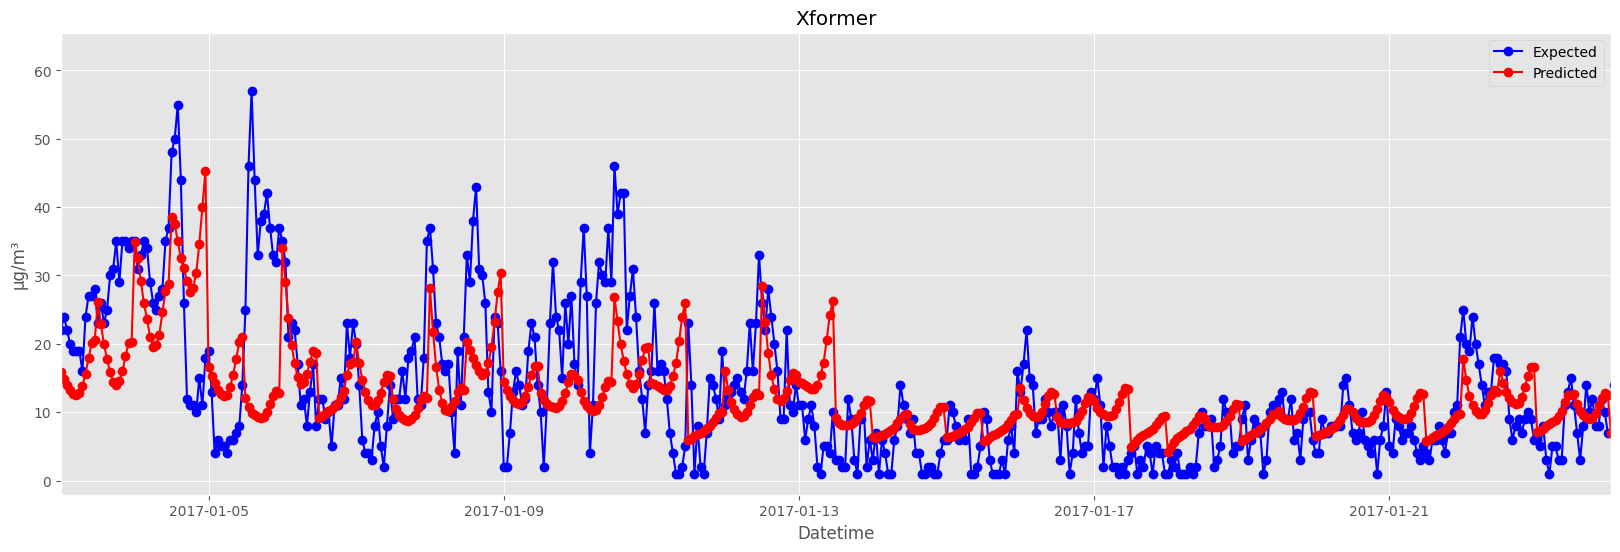

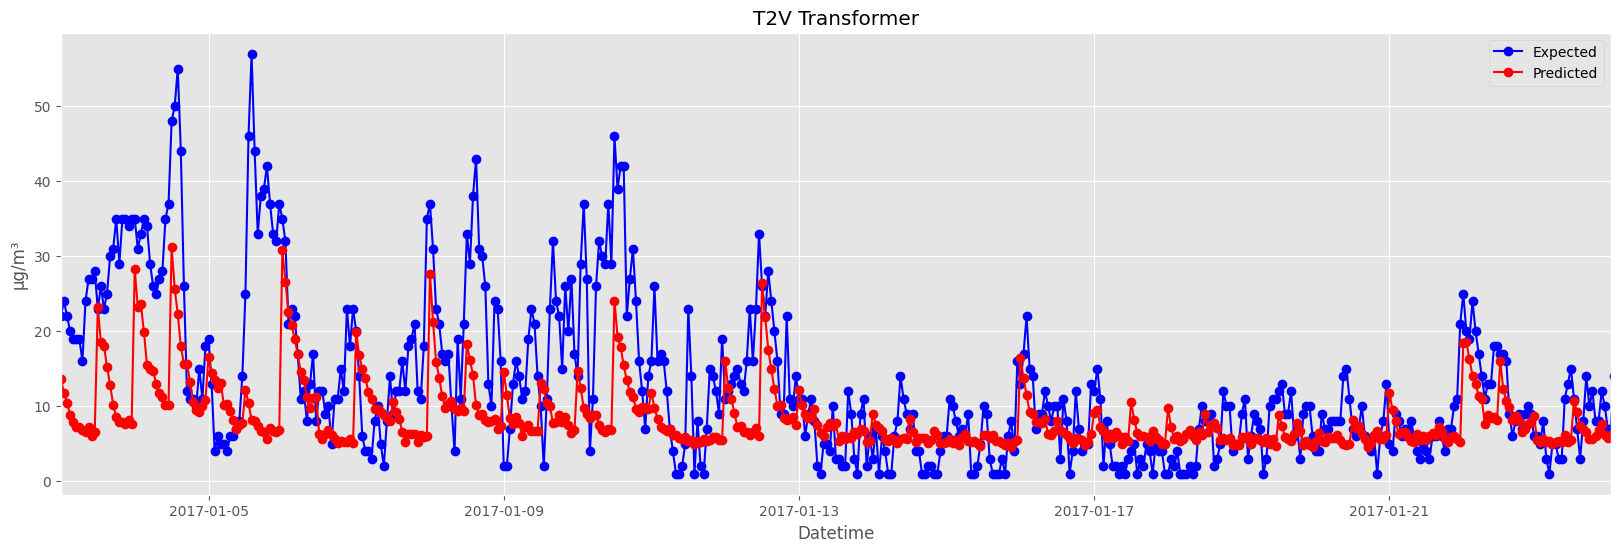

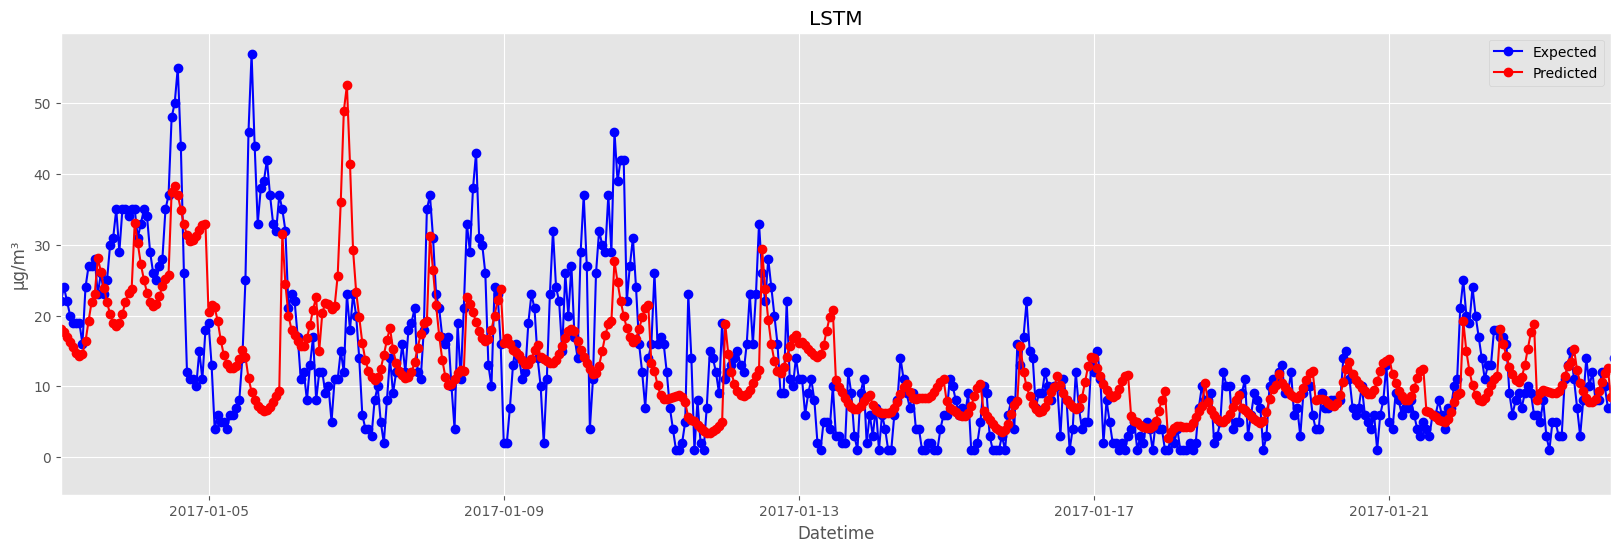

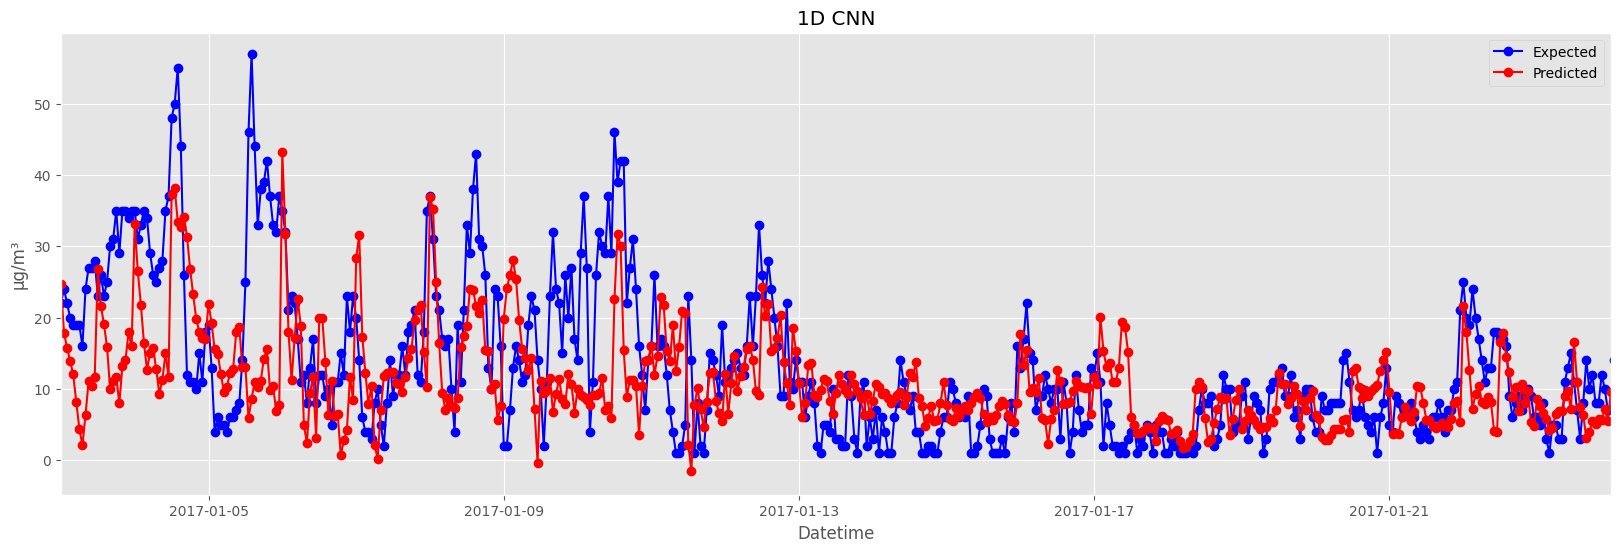

In [147]:
# plot univariate predictions

data_plot(y_test_u_den, preds_xform1_den, 'Xformer')
data_plot(y_test_u_den, preds_t2v_trans1_den, 'T2V Transformer')
data_plot(y_test_u_den, preds_lstm_u_den, 'LSTM')
data_plot(y_test_u_den, preds_cnn1d_u_den, '1D CNN')

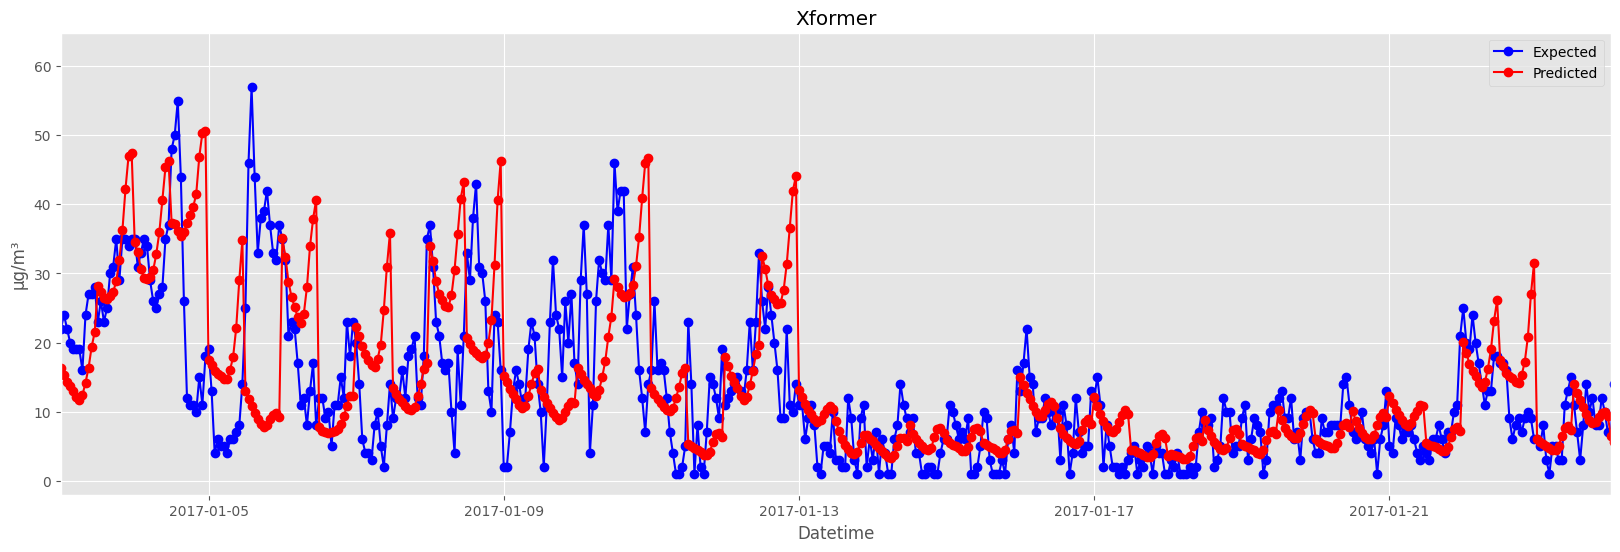

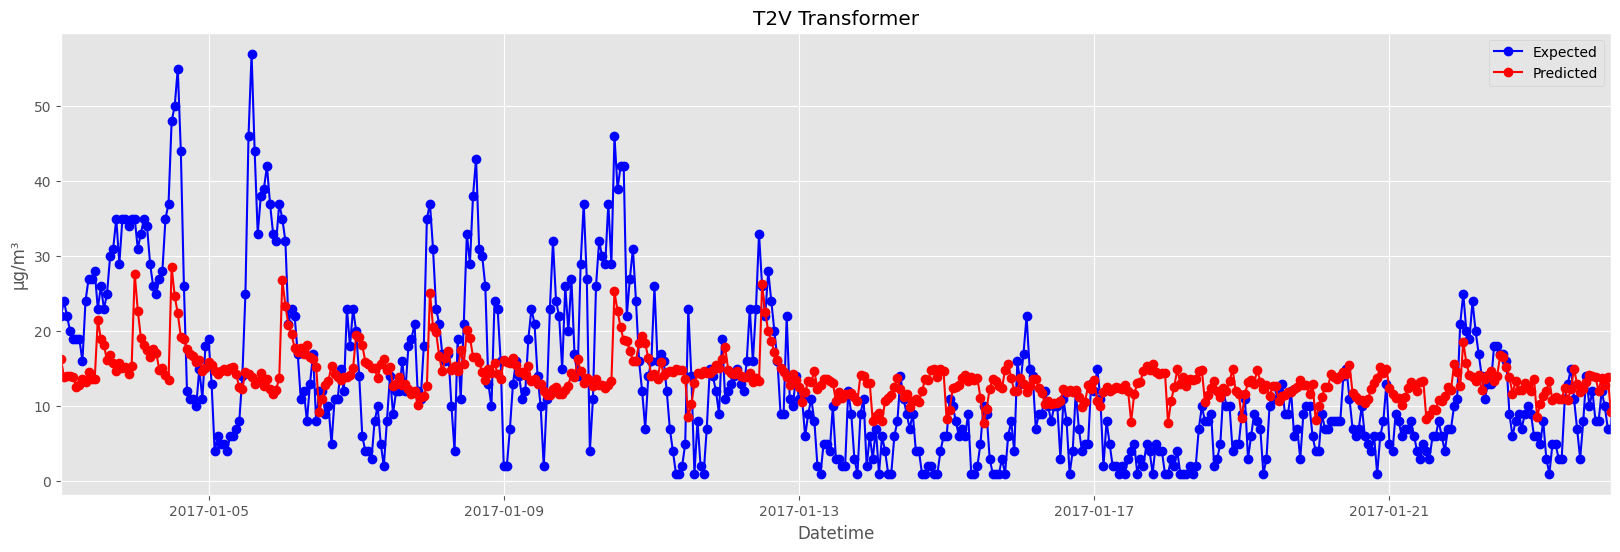

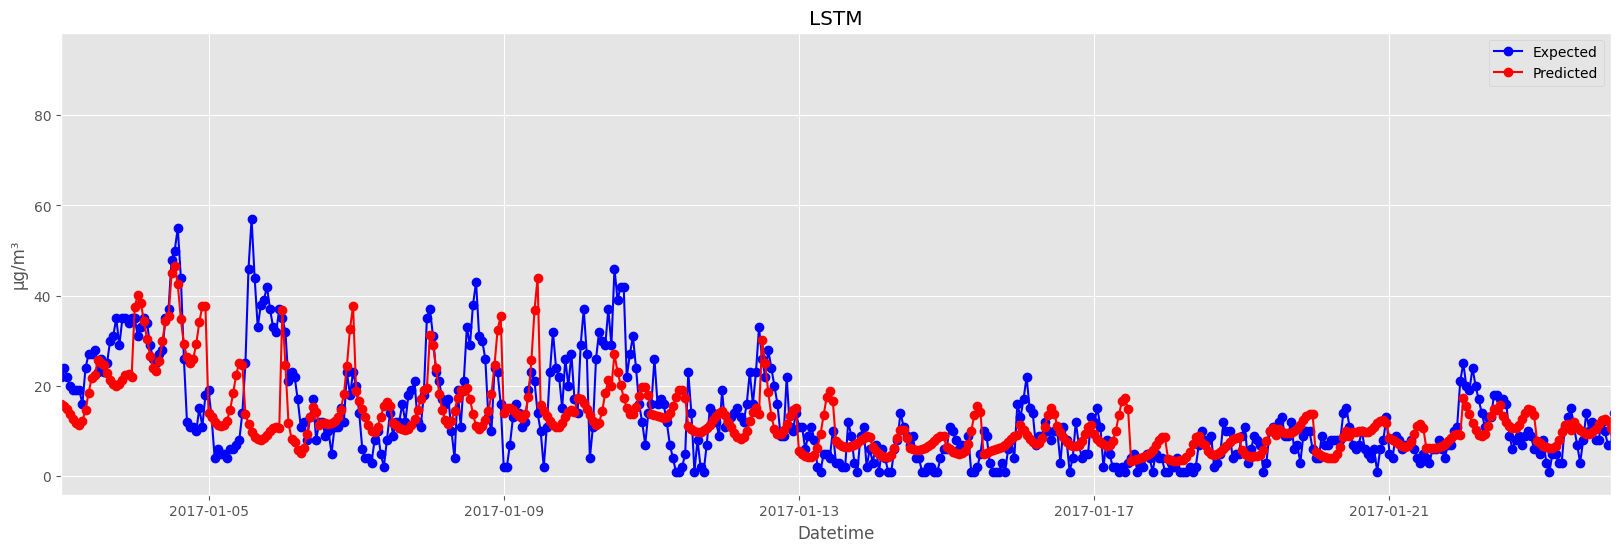

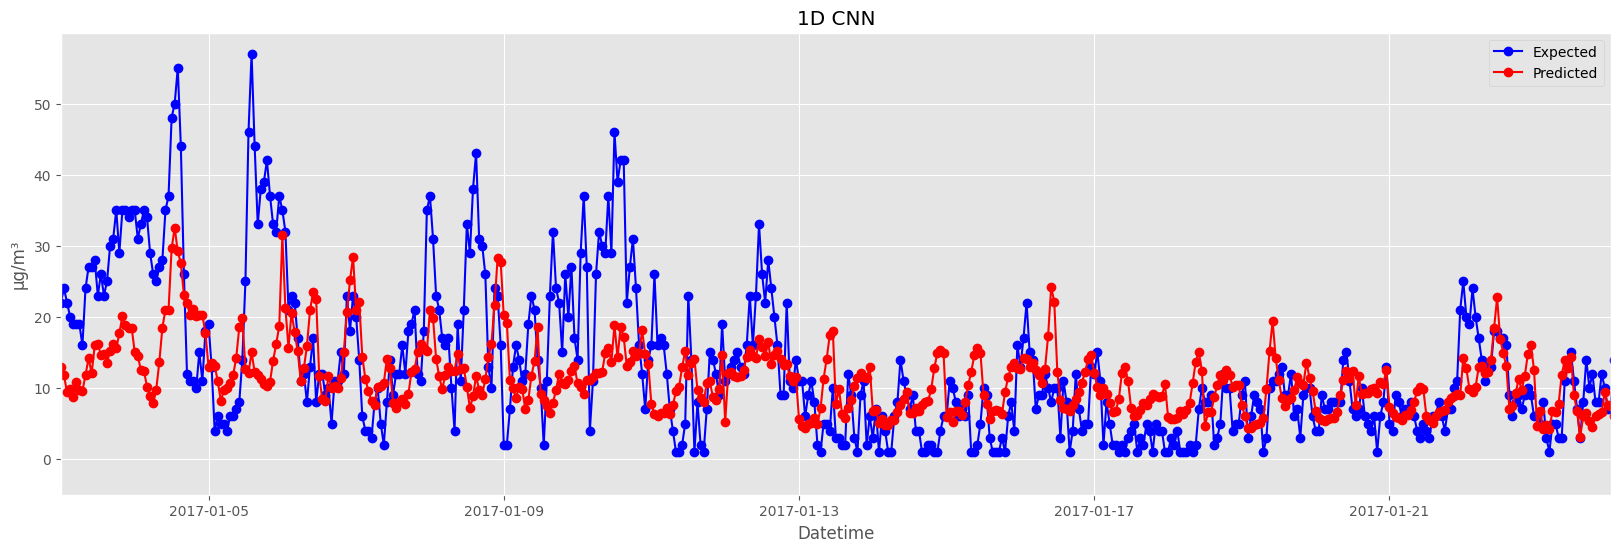

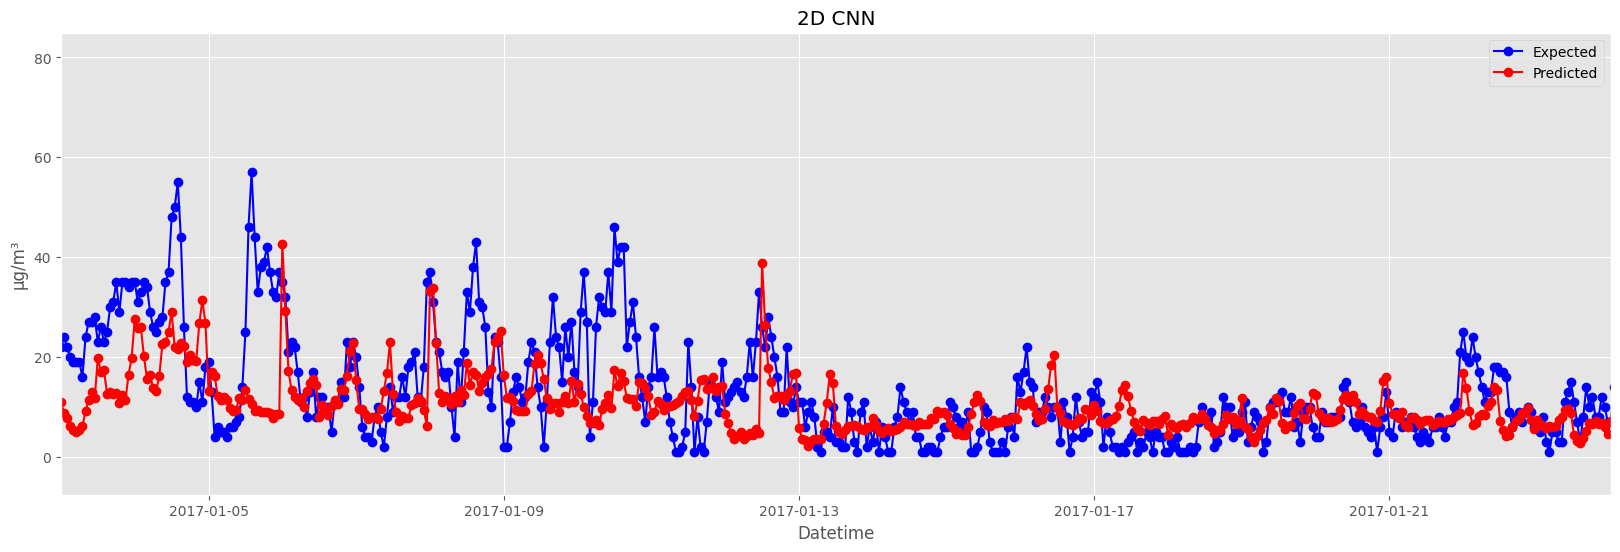

In [146]:
# plot multivariate predictions

data_plot(y_test_m_den, preds_xform2_den, 'Xformer')
data_plot(y_test_m_den, preds_t2v_trans2_den, 'T2V Transformer')
data_plot(y_test_m_den, preds_lstm_m_den, 'LSTM')
data_plot(y_test_m_den, preds_cnn1d_m_den, '1D CNN')
data_plot(y_test_m_den, preds_cnn2d_m_den, '2D CNN')

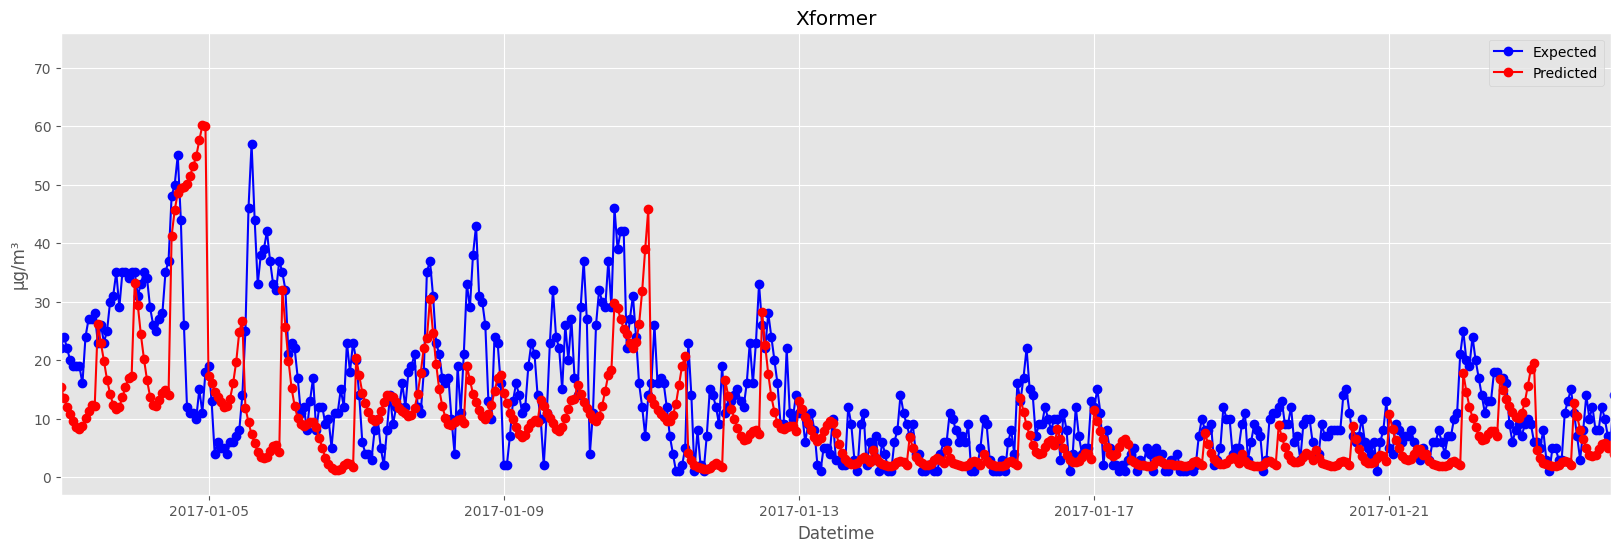

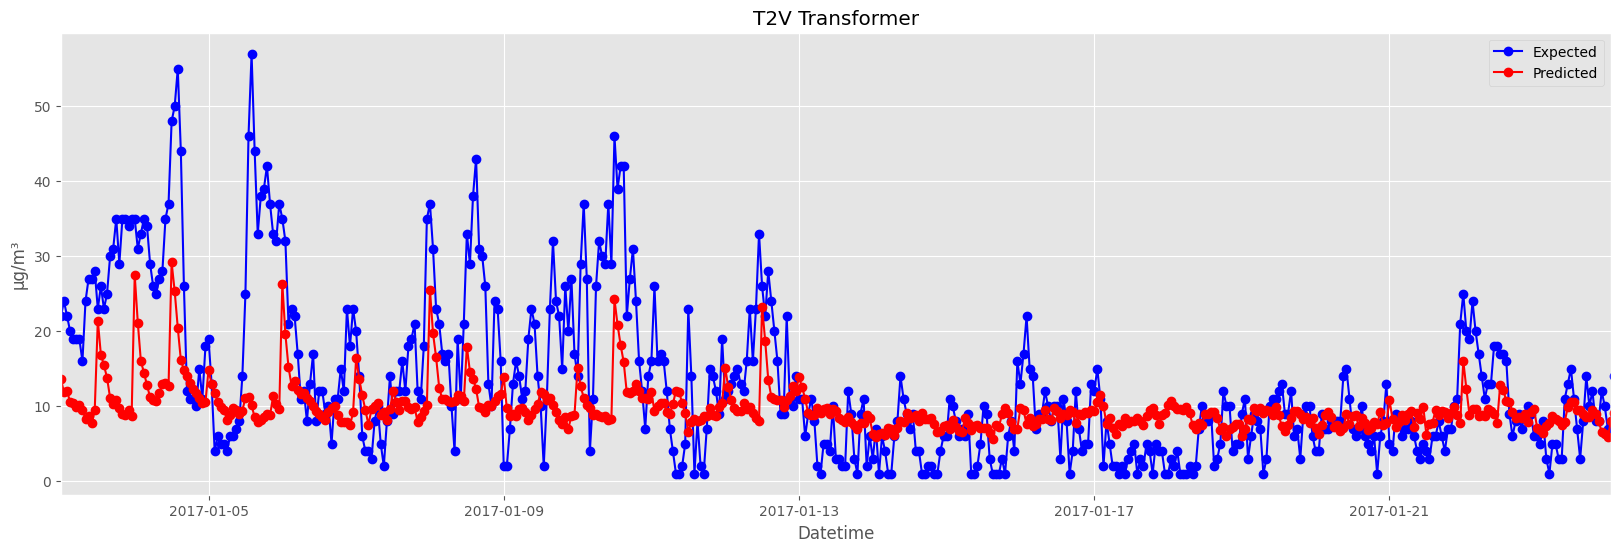

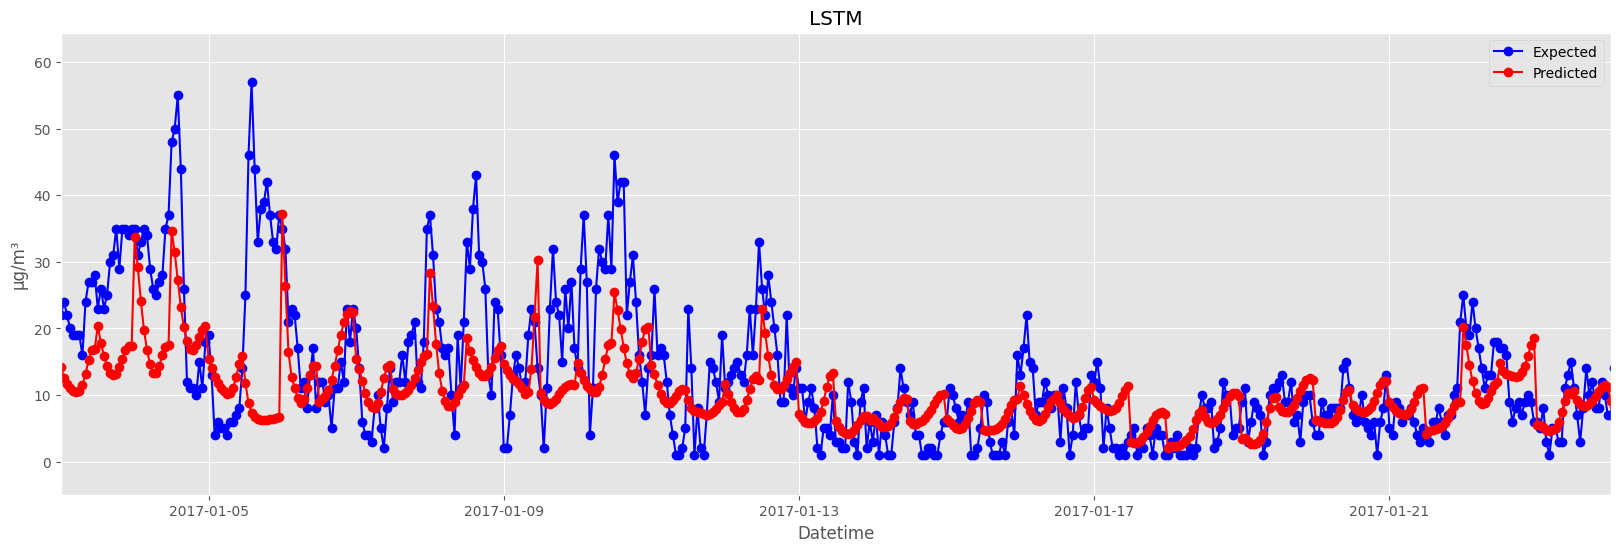

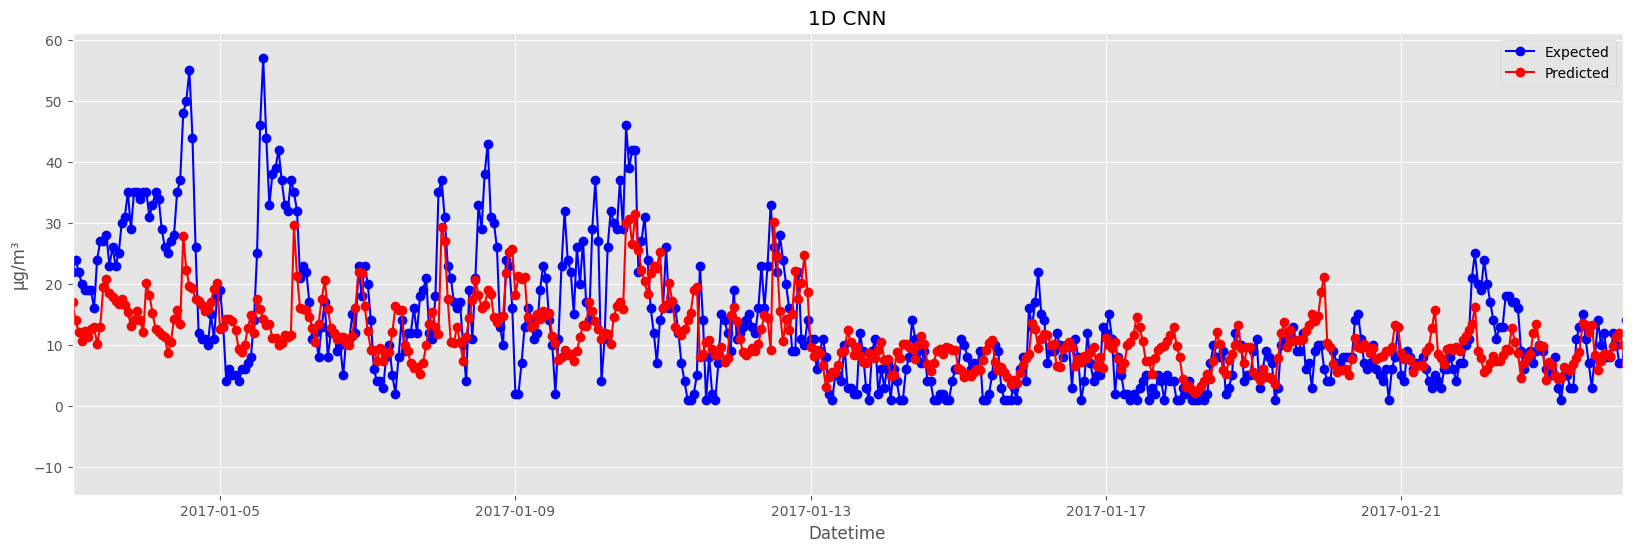

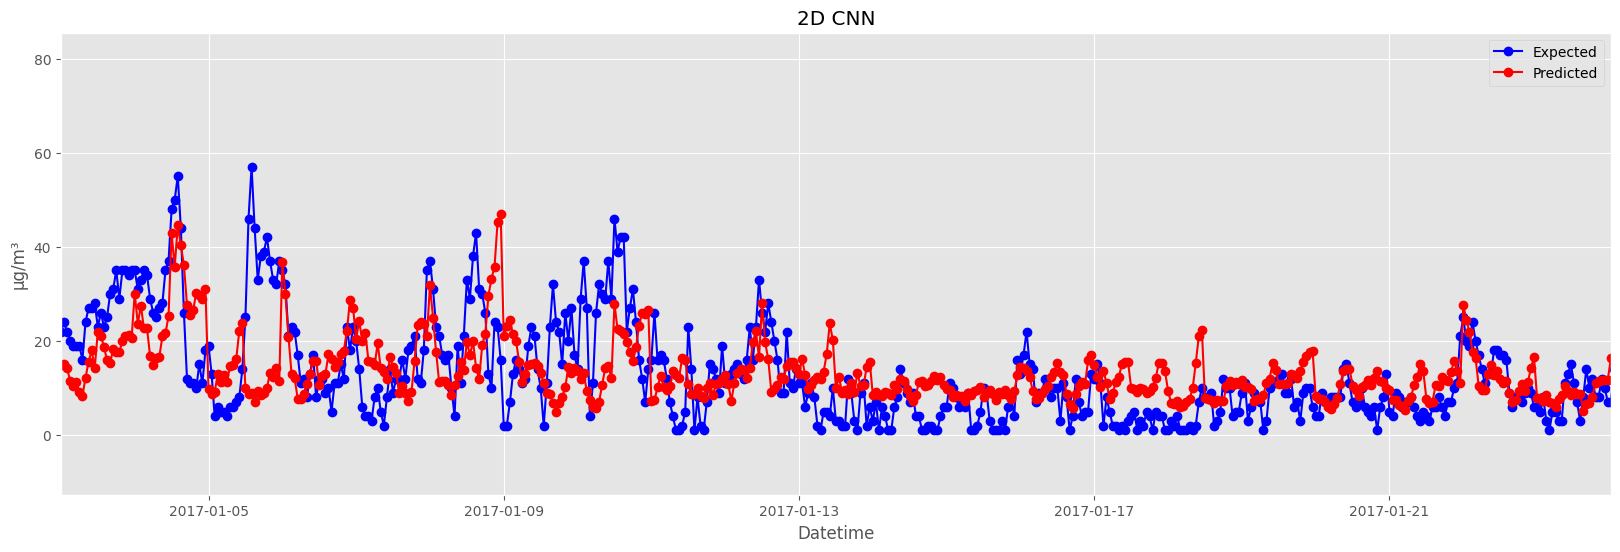

In [145]:
# plot multivariate, pollutants only predictions

data_plot(y_test_mp_den, preds_xform3_den, 'Xformer')
data_plot(y_test_mp_den, preds_t2v_trans3_den, 'T2V Transformer')
data_plot(y_test_mp_den, preds_lstm_mp_den, 'LSTM')
data_plot(y_test_mp_den, preds_cnn1d_mp_den, '1D CNN')
data_plot(y_test_mp_den, preds_cnn2d_mp_den, '2D CNN')

# *7.* Evaluation

`The trained models will be evaluated using the following metrics on the test set, in order to be compared:`

- MAE: mean absolute error
- RMSE: root mean squared error
- NRMSE: normalized root mean squared error (by min-max range)

In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def nrmse(true, pred):
    return mean_squared_error(true, pred, squared=False)/(np.max(true)-np.min(true))

In [141]:
# calculate mean absolute errors

mae_xform_u = mean_absolute_error(y_test_u_den,preds_xform1_den)
mae_t2v_trans_u = mean_absolute_error(y_test_u_den,preds_t2v_trans1_den)
mae_lstm_u = mean_absolute_error(y_test_u_den,preds_lstm_u_den)
mae_cnn1d_u = mean_absolute_error(y_test_u_den,preds_cnn1d_u_den)

print(mae_xform_u, mae_t2v_trans_u, mae_lstm_u, mae_cnn1d_u)

mae_xform_m = mean_absolute_error(y_test_m_den,preds_xform2_den)
mae_t2v_trans_m = mean_absolute_error(y_test_m_den,preds_t2v_trans2_den)
mae_lstm_m = mean_absolute_error(y_test_m_den,preds_lstm_m_den)
mae_cnn1d_m = mean_absolute_error(y_test_m_den,preds_cnn1d_m_den)
mae_cnn2d_m = mean_absolute_error(y_test_m_den,preds_cnn2d_m_den)

print(mae_xform_m, mae_t2v_trans_m, mae_lstm_m, mae_cnn1d_m, mae_cnn2d_m)

mae_xform_mp = mean_absolute_error(y_test_mp_den,preds_xform3_den)
mae_t2v_trans_mp = mean_absolute_error(y_test_mp_den,preds_t2v_trans3_den)
mae_lstm_mp = mean_absolute_error(y_test_mp_den,preds_lstm_mp_den)
mae_cnn1d_mp = mean_absolute_error(y_test_mp_den,preds_cnn1d_mp_den)
mae_cnn2d_mp = mean_absolute_error(y_test_mp_den,preds_cnn2d_mp_den)

print(mae_xform_mp, mae_t2v_trans_mp, mae_lstm_mp, mae_cnn1d_mp, mae_cnn2d_mp)

4.574919 5.1574636 4.469061 5.2471523
5.343486 5.84768 4.5870748 5.0555296 5.1547713
5.7804418 4.8305244 4.3113794 4.789857 5.4396315


In [142]:
# calculate root mean squared errors

rmse_xform_u = mean_squared_error(y_test_u_den,preds_xform1_den, squared=False)
rmse_t2v_trans_u = mean_squared_error(y_test_u_den,preds_t2v_trans1_den, squared=False)
rmse_lstm_u = mean_squared_error(y_test_u_den,preds_lstm_u_den, squared=False)
rmse_cnn1d_u = mean_squared_error(y_test_u_den,preds_cnn1d_u_den, squared=False)

print(rmse_xform_u, rmse_t2v_trans_u, rmse_lstm_u, rmse_cnn1d_u)

rmse_xform_m = mean_squared_error(y_test_m_den,preds_xform2_den, squared=False)
rmse_t2v_trans_m = mean_squared_error(y_test_m_den,preds_t2v_trans2_den, squared=False)
rmse_lstm_m = mean_squared_error(y_test_m_den,preds_lstm_m_den, squared=False)
rmse_cnn1d_m = mean_squared_error(y_test_m_den,preds_cnn1d_m_den, squared=False)
rmse_cnn2d_m = mean_squared_error(y_test_m_den,preds_cnn2d_m_den, squared=False)

print(rmse_xform_m, rmse_t2v_trans_m, rmse_lstm_m, rmse_cnn1d_m, rmse_cnn2d_m)

rmse_xform_mp = mean_squared_error(y_test_mp_den,preds_xform3_den, squared=False)
rmse_t2v_trans_mp = mean_squared_error(y_test_mp_den,preds_t2v_trans3_den, squared=False)
rmse_lstm_mp = mean_squared_error(y_test_mp_den,preds_lstm_mp_den, squared=False)
rmse_cnn1d_mp = mean_squared_error(y_test_mp_den,preds_cnn1d_mp_den, squared=False)
rmse_cnn2d_mp = mean_squared_error(y_test_mp_den,preds_cnn2d_mp_den, squared=False)

print(rmse_xform_mp, rmse_t2v_trans_mp, rmse_lstm_mp, rmse_cnn1d_mp, rmse_cnn2d_mp)

6.021387 7.12806 5.8596964 7.032532
7.563839 7.136107 6.5096846 6.576317 6.940269
7.8287535 6.5939045 5.894174 6.417986 7.188585


In [143]:
# normalized root mean squared errors

nrmse_xform_u = nrmse(y_test_u_den,preds_xform1_den)
nrmse_t2v_trans_u = nrmse(y_test_u_den,preds_t2v_trans1_den)
nrmse_lstm_u = nrmse(y_test_u_den,preds_lstm_u_den)
nrmse_cnn1d_u = nrmse(y_test_u_den,preds_cnn1d_u_den)

print(nrmse_xform_u, nrmse_t2v_trans_u, nrmse_lstm_u, nrmse_cnn1d_u)

nrmse_xform_m = nrmse(y_test_m_den,preds_xform2_den)
nrmse_t2v_trans_m = nrmse(y_test_m_den,preds_t2v_trans2_den)
nrmse_lstm_m = nrmse(y_test_m_den,preds_lstm_m_den)
nrmse_cnn1d_m = nrmse(y_test_m_den,preds_cnn1d_m_den)
nrmse_cnn2d_m = nrmse(y_test_m_den,preds_cnn2d_m_den)

print(nrmse_xform_m, nrmse_t2v_trans_m, nrmse_lstm_m, nrmse_cnn1d_m, nrmse_cnn2d_m)

nrmse_xform_mp = nrmse(y_test_mp_den,preds_xform3_den)
nrmse_t2v_trans_mp = nrmse(y_test_mp_den,preds_t2v_trans3_den)
nrmse_lstm_mp = nrmse(y_test_mp_den,preds_lstm_mp_den)
nrmse_cnn1d_mp = nrmse(y_test_mp_den,preds_cnn1d_mp_den)
nrmse_cnn2d_mp = nrmse(y_test_mp_den,preds_cnn2d_mp_den)

print(nrmse_xform_mp, nrmse_t2v_trans_mp, nrmse_lstm_mp, nrmse_cnn1d_mp, nrmse_cnn2d_mp)

0.10752477 0.12728678 0.10463744 0.12558094
0.13506855 0.12743048 0.11624437 0.117434226 0.123933375
0.13979916 0.1177483 0.10525311 0.114606895 0.12836759


# Notebook references:   

- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer#training)
- [How to make a Transformer for time series forecasting with PyTorch](https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e)
- [How to run inference with a PyTorch time series Transformer](https://towardsdatascience.com/how-to-run-inference-with-a-pytorch-time-series-transformer-394fd6cbe16c)
- [Time-Series Forecasting GRU vs Transformers](https://www.kaggle.com/code/chanlilong/time-series-forecasting-gru-vs-transformers/notebook)